# Bib

In [1]:
import warnings
import itertools
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

2025-04-30 23:07:02.842759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-30 23:07:02.842867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-30 23:07:02.897575: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 23:07:03.011151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 23:07:04.309398: W tensorflow/compiler/tf2

In [3]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Visualization

In [4]:
ts = pd.read_csv("MER_T12_06.csv")
ts

MSN  YYYYMM    Value  Column_Order  \
0     CLEIEUS  197301   72.076             1   
1     CLEIEUS  197302   64.442             1   
2     CLEIEUS  197303   64.084             1   
3     CLEIEUS  197304   60.842             1   
4     CLEIEUS  197305   61.798             1   
...       ...     ...      ...           ...   
5089  TXEIEUS  201603  115.997             9   
5090  TXEIEUS  201604  113.815             9   
5091  TXEIEUS  201605   129.44             9   
5092  TXEIEUS  201606  172.074             9   
5093  TXEIEUS  201607  201.958             9   

                                           Description  \
0             Coal Electric Power Sector CO2 Emissions   
1             Coal Electric Power Sector CO2 Emissions   
2             Coal Electric Power Sector CO2 Emissions   
3             Coal Electric Power Sector CO2 Emissions   
4             Coal Electric Power Sector CO2 Emissions   
...                                                ...   
5089  Total Energy Electric Power Sector CO2 Emissions   
5090  Total Energy Electric Power Sector CO2 Emissions   
5091  Total Energy Electric Power Sector CO2 Emissions   
5092  Total Energy Electric Power Sector CO2 Emissions   
5093  Total Energy Electric Power Sector CO2 Emissions   

                                       Unit  
0     Million Metric Tons of Carbon Dioxide  
1     Million Metric Tons of Carbon Dioxide  
2     Million Metric Tons of Carbon Dioxide  
3     Million Metric Tons of Carbon Dioxide  
4     Million Metric Tons of Carbon Dioxide  
...                                     ...  
5089  Million Metric Tons of Carbon Dioxide  
5090  Million Metric Tons of Carbon Dioxide  
5091  Million Metric Tons of Carbon Dioxide  
5092  Million Metric Tons of Carbon Dioxide  
5093  Million Metric Tons of Carbon Dioxide  

[5094 rows x 6 columns]

In [5]:
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
ts = pd.read_csv("MER_T12_06.csv", parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 

In [6]:
ts = ts[pd.Series(pd.to_datetime(ts.index, errors='coerce')).notnull().values]
ts.head()

MSN   Value  Column_Order  \
YYYYMM                                      
1973-01-01  CLEIEUS  72.076             1   
1973-02-01  CLEIEUS  64.442             1   
1973-03-01  CLEIEUS  64.084             1   
1973-04-01  CLEIEUS  60.842             1   
1973-05-01  CLEIEUS  61.798             1   

                                         Description  \
YYYYMM                                                 
1973-01-01  Coal Electric Power Sector CO2 Emissions   
1973-02-01  Coal Electric Power Sector CO2 Emissions   
1973-03-01  Coal Electric Power Sector CO2 Emissions   
1973-04-01  Coal Electric Power Sector CO2 Emissions   
1973-05-01  Coal Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-03-01  Million Metric Tons of Carbon Dioxide  
1973-04-01  Million Metric Tons of Carbon Dioxide  
1973-05-01  Million Metric Tons of Carbon Dioxide

In [7]:
ts.isnull().sum()

MSN             0
Value           0
Column_Order    0
Description     0
Unit            0
dtype: int64

In [8]:
ts.dropna(inplace = True)

In [9]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           4707 non-null   object
 1   Value         4707 non-null   object
 2   Column_Order  4707 non-null   int64 
 3   Description   4707 non-null   object
 4   Unit          4707 non-null   object
dtypes: int64(1), object(4)
memory usage: 220.6+ KB


In [10]:
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
ts.head()

MSN   Value  Column_Order  \
YYYYMM                                      
1973-01-01  CLEIEUS  72.076             1   
1973-02-01  CLEIEUS  64.442             1   
1973-03-01  CLEIEUS  64.084             1   
1973-04-01  CLEIEUS  60.842             1   
1973-05-01  CLEIEUS  61.798             1   

                                         Description  \
YYYYMM                                                 
1973-01-01  Coal Electric Power Sector CO2 Emissions   
1973-02-01  Coal Electric Power Sector CO2 Emissions   
1973-03-01  Coal Electric Power Sector CO2 Emissions   
1973-04-01  Coal Electric Power Sector CO2 Emissions   
1973-05-01  Coal Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-03-01  Million Metric Tons of Carbon Dioxide  
1973-04-01  Million Metric Tons of Carbon Dioxide  
1973-05-01  Million Metric Tons of Carbon Dioxide

In [11]:
ts['MSN'].value_counts()

MSN
CLEIEUS    523
NNEIEUS    523
DKEIEUS    523
PCEIEUS    523
RFEIEUS    523
PAEIEUS    523
GEEIEUS    523
NWEIEUS    523
TXEIEUS    523
Name: count, dtype: int64

In [12]:
le = LabelEncoder()
ts['msn_encoded'] = le.fit_transform(ts['MSN'])

In [13]:
ts.duplicated().sum()

1245

In [14]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSN           4707 non-null   object 
 1   Value         4323 non-null   float64
 2   Column_Order  4707 non-null   int64  
 3   Description   4707 non-null   object 
 4   Unit          4707 non-null   object 
 5   msn_encoded   4707 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 257.4+ KB


In [15]:
ts.dropna(inplace = True)

# Exploration des données : 

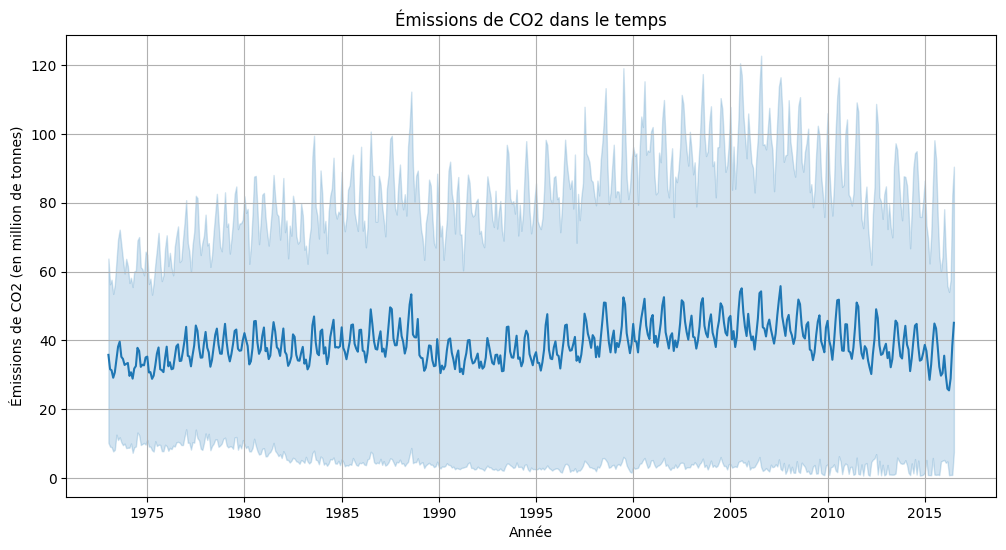

In [16]:
# Affichage graphique
plt.figure(figsize=(12, 6))
sns.lineplot(data=ts, x=ts.index, y='Value')
plt.title("Émissions de CO2 dans le temps")
plt.xlabel("Année")
plt.ylabel("Émissions de CO2 (en million de tonnes)")
plt.grid()
plt.show()

In [17]:
Energy_sources = ts.groupby('Description')
Energy_sources.head()

MSN    Value  Column_Order  \
YYYYMM                                       
1973-01-01  CLEIEUS   72.076             1   
1973-02-01  CLEIEUS   64.442             1   
1973-03-01  CLEIEUS   64.084             1   
1973-04-01  CLEIEUS   60.842             1   
1973-05-01  CLEIEUS   61.798             1   
1973-01-01  NNEIEUS   12.175             2   
1973-02-01  NNEIEUS   11.708             2   
1973-03-01  NNEIEUS   13.994             2   
1973-04-01  NNEIEUS   14.627             2   
1973-05-01  NNEIEUS   17.344             2   
1973-01-01  DKEIEUS    2.375             3   
1973-02-01  DKEIEUS    2.061             3   
1973-03-01  DKEIEUS    1.171             3   
1973-04-01  DKEIEUS    1.022             3   
1973-05-01  DKEIEUS    0.949             3   
1973-01-01  PCEIEUS    0.128             4   
1973-02-01  PCEIEUS    0.106             4   
1973-03-01  PCEIEUS    0.083             4   
1973-04-01  PCEIEUS    0.130             4   
1973-05-01  PCEIEUS    0.167             4   
1973-01-01  RFEIEUS   24.867             5   
1973-02-01  RFEIEUS   20.867             5   
1973-03-01  RFEIEUS   19.780             5   
1973-04-01  RFEIEUS   16.562             5   
1973-05-01  RFEIEUS   17.754             5   
1973-01-01  PAEIEUS   27.369             6   
1973-02-01  PAEIEUS   23.034             6   
1973-03-01  PAEIEUS   21.034             6   
1973-04-01  PAEIEUS   17.714             6   
1973-05-01  PAEIEUS   18.870             6   
1989-01-01  GEEIEUS    0.031             7   
1989-02-01  GEEIEUS    0.028             7   
1989-03-01  GEEIEUS    0.031             7   
1989-04-01  GEEIEUS    0.030             7   
1989-05-01  GEEIEUS    0.031             7   
1989-01-01  NWEIEUS    0.371             8   
1989-02-01  NWEIEUS    0.335             8   
1989-03-01  NWEIEUS    0.371             8   
1989-04-01  NWEIEUS    0.359             8   
1989-05-01  NWEIEUS    0.371             8   
1973-01-01  TXEIEUS  111.621             9   
1973-02-01  TXEIEUS   99.185             9   
1973-03-01  TXEIEUS   99.112             9   
1973-04-01  TXEIEUS   93.183             9   
1973-05-01  TXEIEUS   98.012             9   

                                                  Description  \
YYYYMM                                                          
1973-01-01           Coal Electric Power Sector CO2 Emissions   
1973-02-01           Coal Electric Power Sector CO2 Emissions   
1973-03-01           Coal Electric Power Sector CO2 Emissions   
1973-04-01           Coal Electric Power Sector CO2 Emissions   
1973-05-01           Coal Electric Power Sector CO2 Emissions   
1973-01-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-02-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-03-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-04-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-05-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-01-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-02-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-03-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-04-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-05-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-01-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-02-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-03-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-04-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-05-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-01-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-02-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-03-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-04-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-05-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-01-01      Petroleum Electric Power Sector CO2 Emissions   
1973-02-01      Petroleum Electri

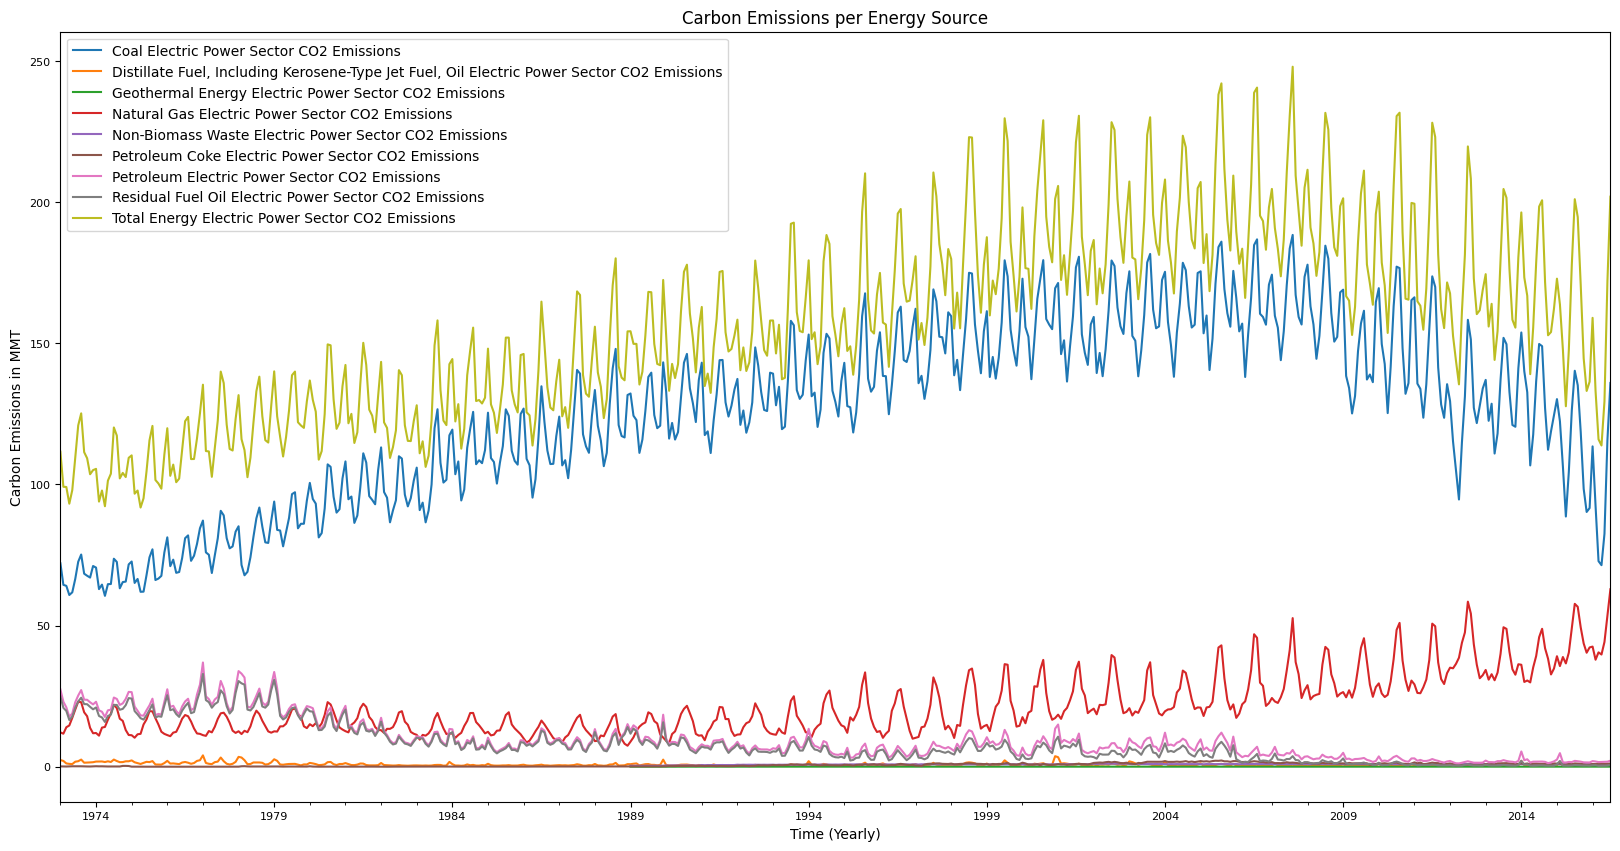

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))

for desc, group in Energy_sources:
    group.plot(
        y='Value', 
        label=desc, 
        ax=ax, 
        title='Carbon Emissions per Energy Source', 
        fontsize=8
    )

ax.set_xlabel('Time (Yearly)')
ax.set_ylabel('Carbon Emissions in MMT')
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.legend(fontsize=10)


Individually, we can visualize the trend and seasonality effect on CO2 emission from each energy source. For example, the CO2 emission from coal shows a trend of increment from 1973 to 2006 and then declines till 2016. 

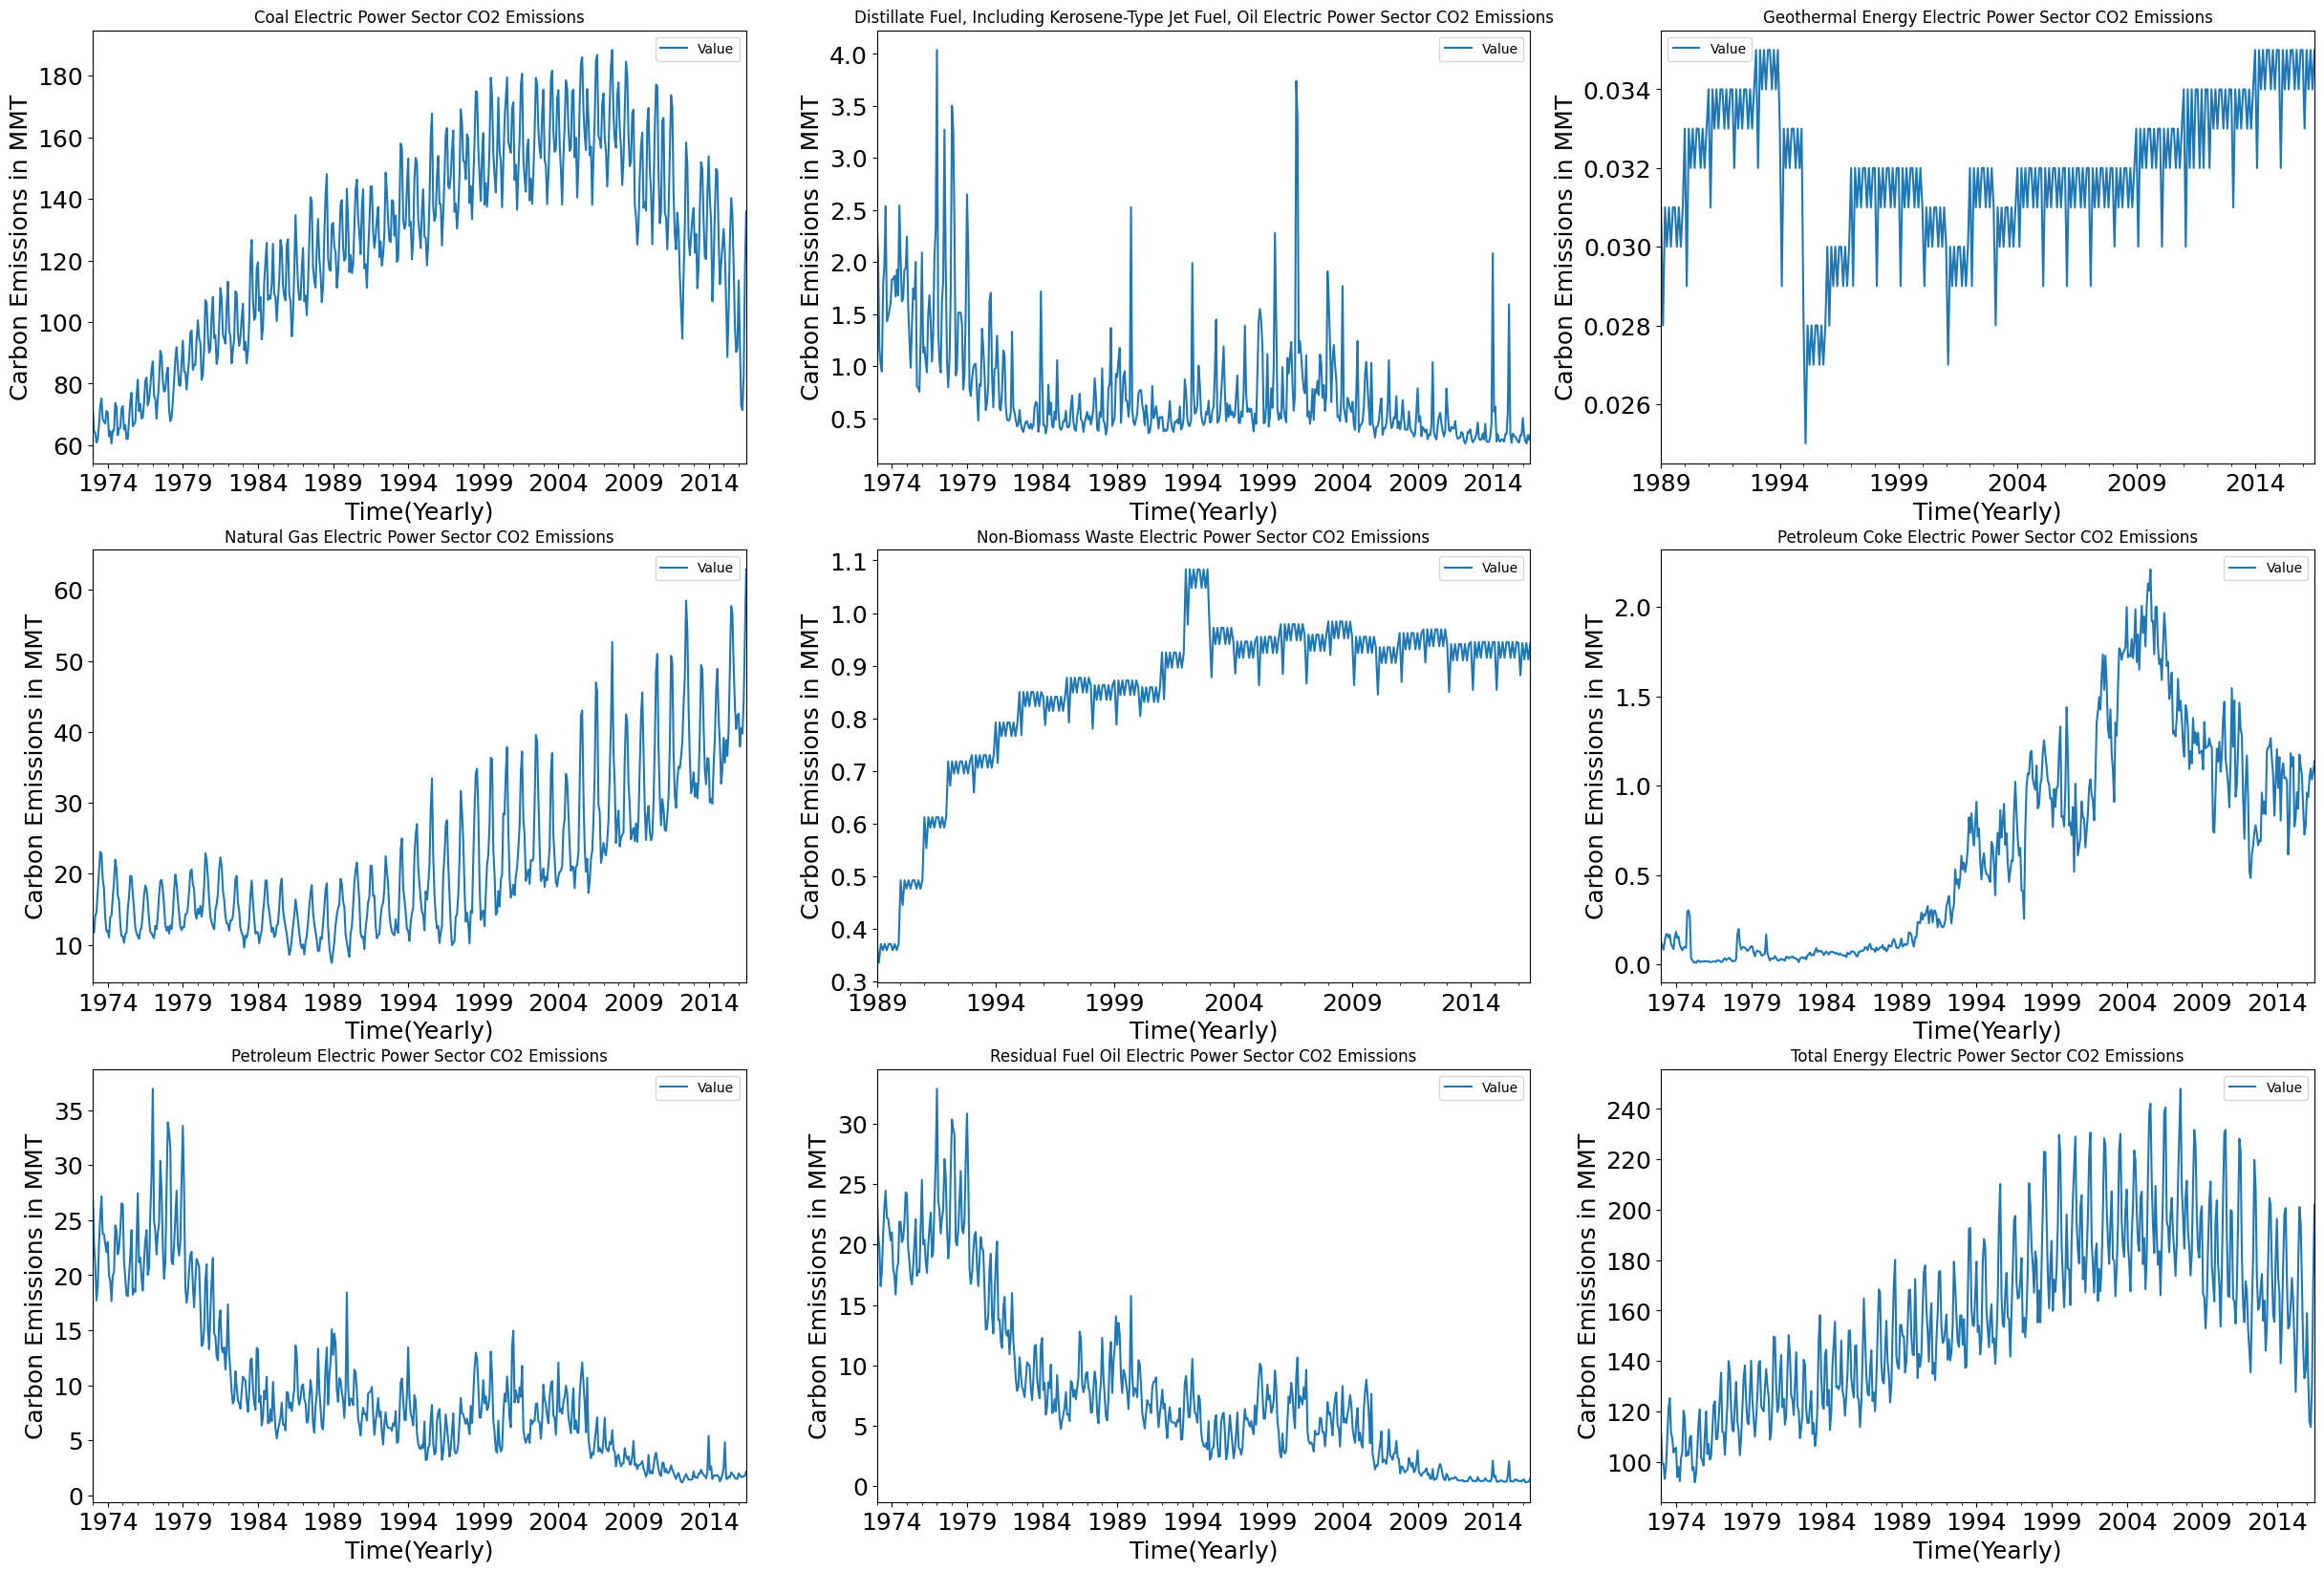

In [19]:
fig, axes = plt.subplots(3,3, figsize = (30, 20))
for (desc, group), ax in zip(Energy_sources, axes.flatten()):
    group.plot( y='Value',ax = ax, title=desc, fontsize = 18)
    ax.set_xlabel('Time(Yearly)')
    ax.set_ylabel('Carbon Emissions in MMT')
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

In recent years, the natural gas consumption has been increasing. However, the use of coal for power generation has been declining. The plots of CO2 emissions from coal and natural gas show this trend, while declining the CO2 contribution from coal, there is an increment in the contribution of CO2 emission from natural gas.


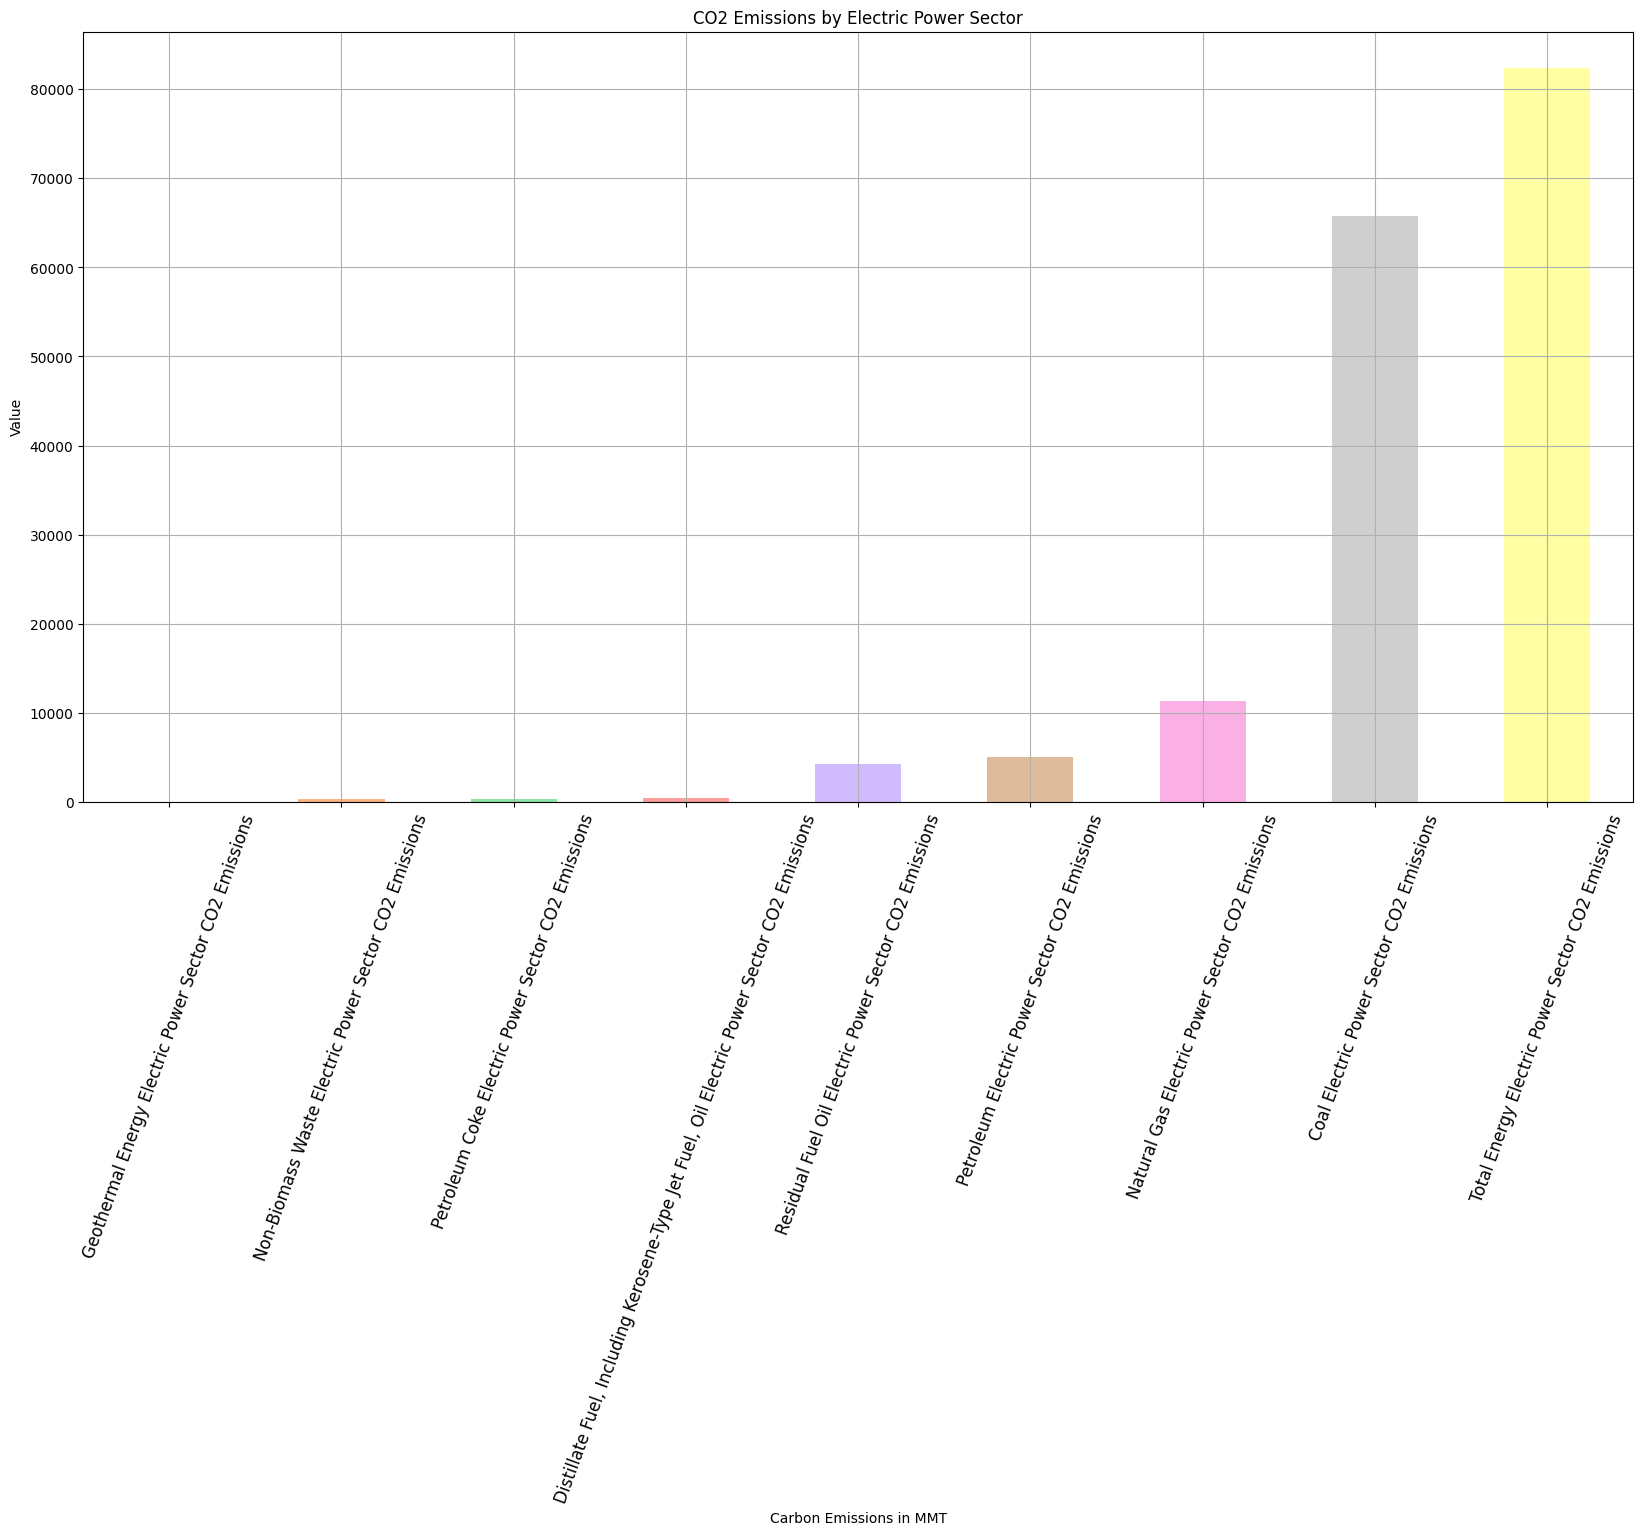

In [20]:
CO2_per_source = ts.groupby('Description')['Value'].sum().sort_values()
# Génération de la palette de couleurs
colors = sns.color_palette("pastel", len(CO2_per_source))

# Création de la figure et de l'axe
plt.figure(figsize=(20, 10))

# Tracé de la ligne
CO2_per_source.plot(kind='bar', color=colors)

# Ajout du titre et des labels
plt.title("CO2 Emissions by Electric Power Sector")
plt.xticks(rotation = 70, fontsize = 12)
plt.xlabel('Carbon Emissions in MMT')
plt.ylabel('Value')

# Ajouter une grille pour mieux visualiser
plt.grid(True)

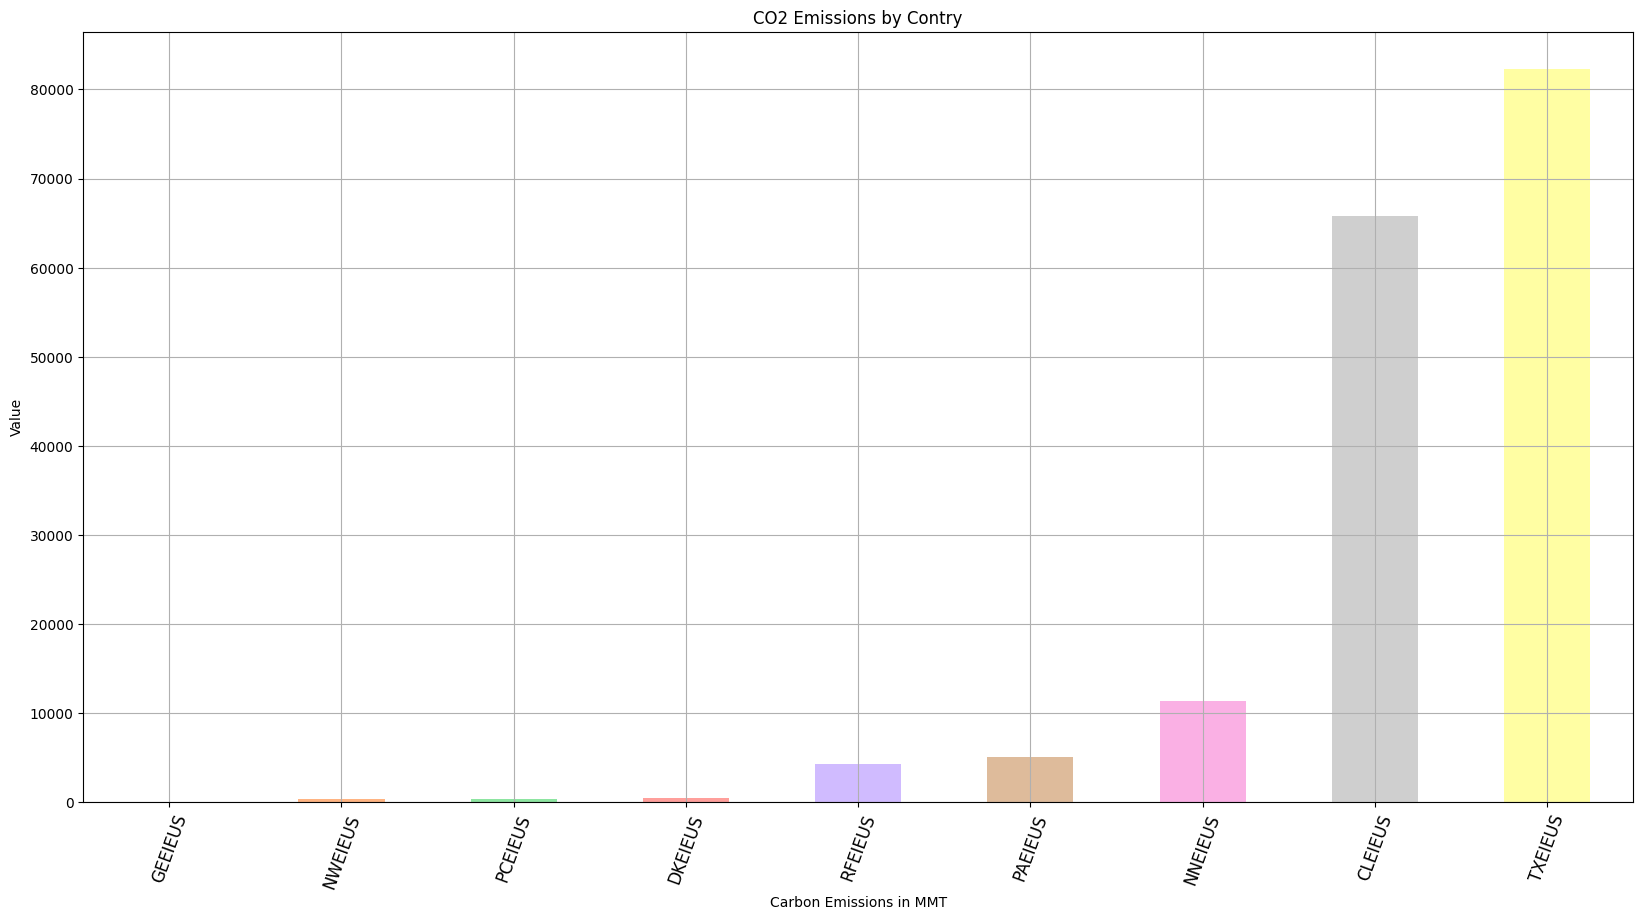

In [21]:
CO2_per_cont = ts.groupby('MSN')['Value'].sum().sort_values()
# Génération de la palette de couleurs
colors = sns.color_palette("pastel", len(CO2_per_cont))

# Création de la figure et de l'axe
plt.figure(figsize=(20, 10))

# Tracé de la ligne
CO2_per_cont.plot(kind='bar', color=colors)

# Ajout du titre et des labels
plt.title("CO2 Emissions by Contry")
plt.xticks(rotation = 70, fontsize = 12)
plt.xlabel('Carbon Emissions in MMT')
plt.ylabel('Value')

# Ajouter une grille pour mieux visualiser
plt.grid(True)

Conclusion all columns are the same

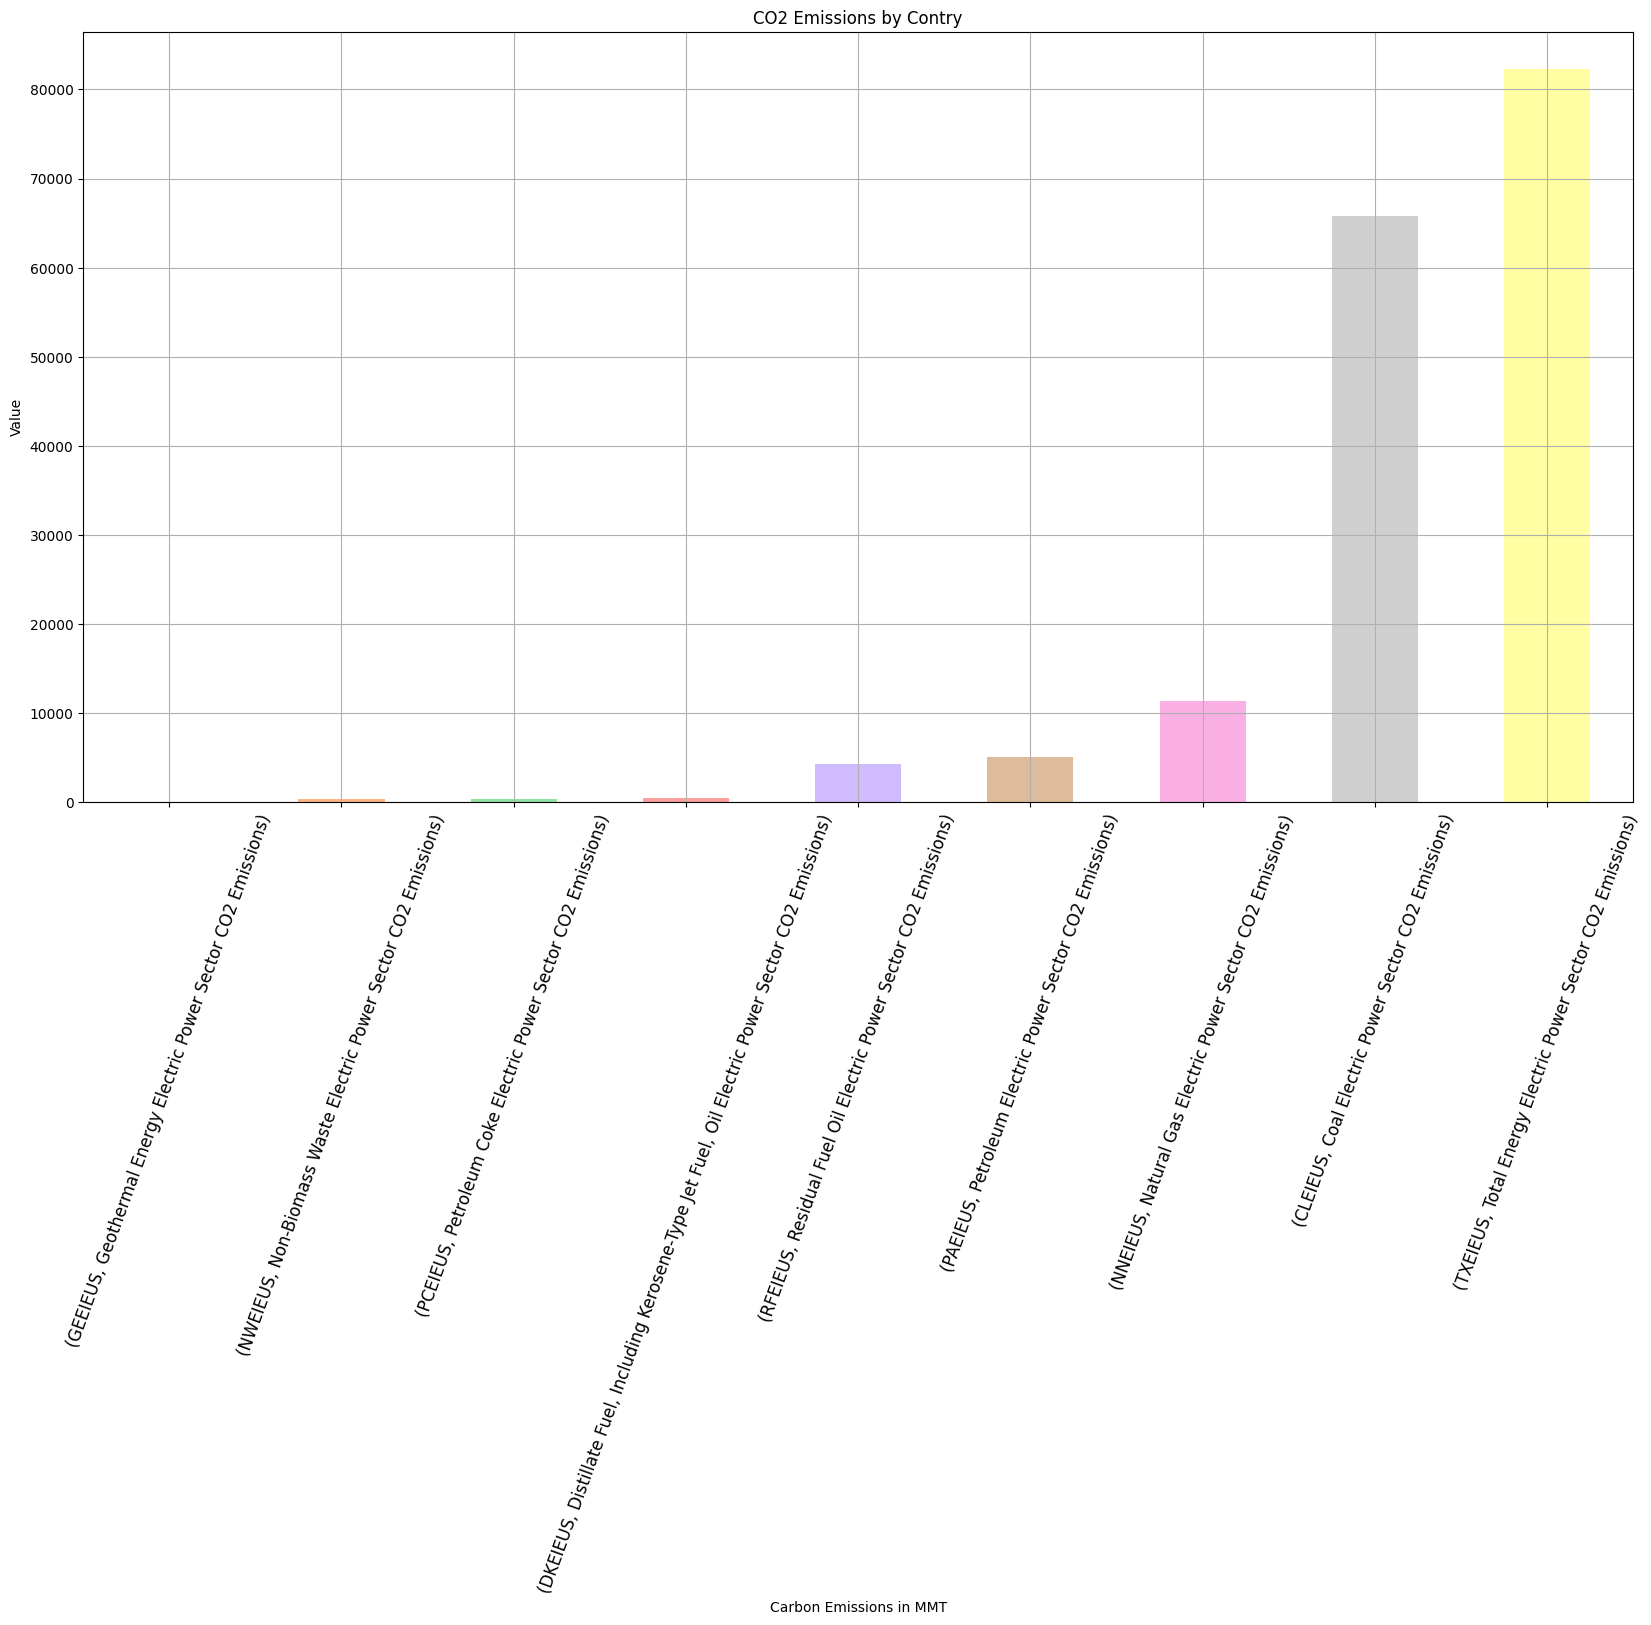

In [22]:
CO2_per_cont_des = ts.groupby(['MSN','Description'])['Value'].sum().sort_values()
# Génération de la palette de couleurs
colors = sns.color_palette("pastel", len(CO2_per_cont_des))

# Création de la figure et de l'axe
plt.figure(figsize=(20, 10))

# Tracé de la ligne
CO2_per_cont_des.plot(kind='bar', color=colors)

# Ajout du titre et des labels
plt.title("CO2 Emissions by Contry")
plt.xticks(rotation = 70, fontsize = 12)
plt.xlabel('Carbon Emissions in MMT')
plt.ylabel('Value')

# Ajouter une grille pour mieux visualiser
plt.grid(True)

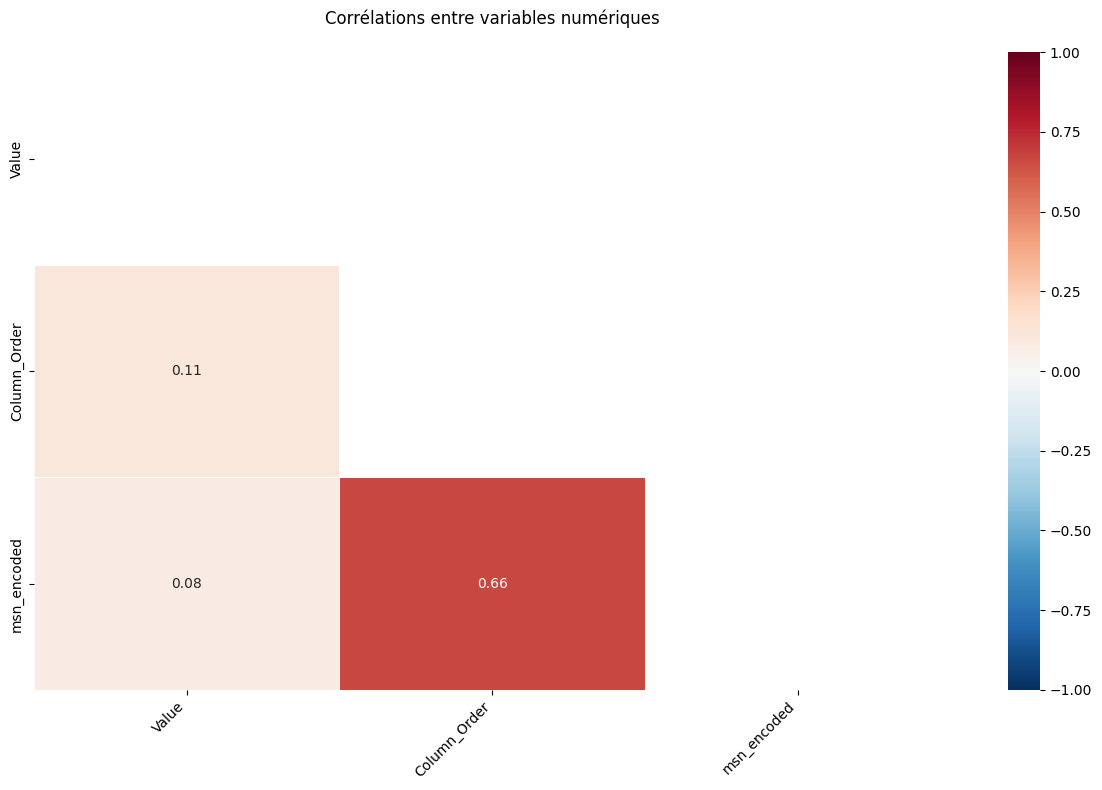

In [23]:
# Sélectionner uniquement les colonnes numériques
numeric_cols = ts.select_dtypes(include=['float64', 'int64']).columns
df_numeric = ts[numeric_cols].dropna()  # Supprimer les NaN

matrix_corr = df_numeric.corr(method='pearson')

# Masque pour triangularisation (éviter la redondance)
mask = np.triu(np.ones_like(matrix_corr, dtype=bool))

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_corr,
            mask=mask,
            cmap='RdBu_r',
            annot=True,
            fmt=".2f",  # Format à 2 décimales
            linewidths=0.5,
            vmin=-1, vmax=1,
            center=0)

plt.title("Corrélations entre variables numériques", pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
# Pivot the table: Rows=Year, Columns=Emission Type, Values=CO2 Value
pivot_table = ts.pivot_table(
    index = ts.index,
    columns='Description', # Emission types (Coal, Oil, Gas)
    values='Value',       # CO2 values
    aggfunc='mean'        # Use mean if duplicates exist
)

pivot_table

Description  Coal Electric Power Sector CO2 Emissions  \
YYYYMM                                                  
1973-01-01                                     72.076   
1973-02-01                                     64.442   
1973-03-01                                     64.084   
1973-04-01                                     60.842   
1973-05-01                                     61.798   
...                                               ...   
2016-03-01                                     72.840   
2016-04-01                                     71.410   
2016-05-01                                     82.510   
2016-06-01                                    115.772   
2016-07-01                                    135.958   

Description  Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions  \
YYYYMM                                                                                                    
1973-01-01                                               2.375                                            
1973-02-01                                               2.061                                            
1973-03-01                                               1.171                                            
1973-04-01                                               1.022                                            
1973-05-01                                               0.949                                            
...                                                        ...                                            
2016-03-01                                               0.279                                            
2016-04-01                                               0.259                                            
2016-05-01                                               0.340                                            
2016-06-01                                               0.293                                            
2016-07-01                                               0.342                                            

Description  Geothermal Energy Electric Power Sector CO2 Emissions  \
YYYYMM                                                               
1973-01-01                                                 NaN       
1973-02-01                                                 NaN       
1973-03-01                                                 NaN       
1973-04-01                                                 NaN       
1973-05-01                                                 NaN       
...                                                        ...       
2016-03-01                                               0.035       
2016-04-01                                               0.034       
2016-05-01                                               0.035       
2016-06-01                                               0.034       
2016-07-01                                               0.035       

Description  Natural Gas Electric Power Sector CO2 Emissions  \
YYYYMM                                                         
1973-01-01                                            12.175   
1973-02-01                                            11.708   
1973-03-01                                            13.994   
1973-04-01                                            14.627   
1973-05-01                                            17.344   
...                                                      ...   
2016-03-01                                            40.525   
2016-04-01                                            39.763   
2016-05-01                                            44.210   
2016-06-01                                            53.567   
2016-07-01                                            62.881   

Description  Non-Biomass Waste Electric Power Sector CO2 Emissions  \
YYYYMM                                              

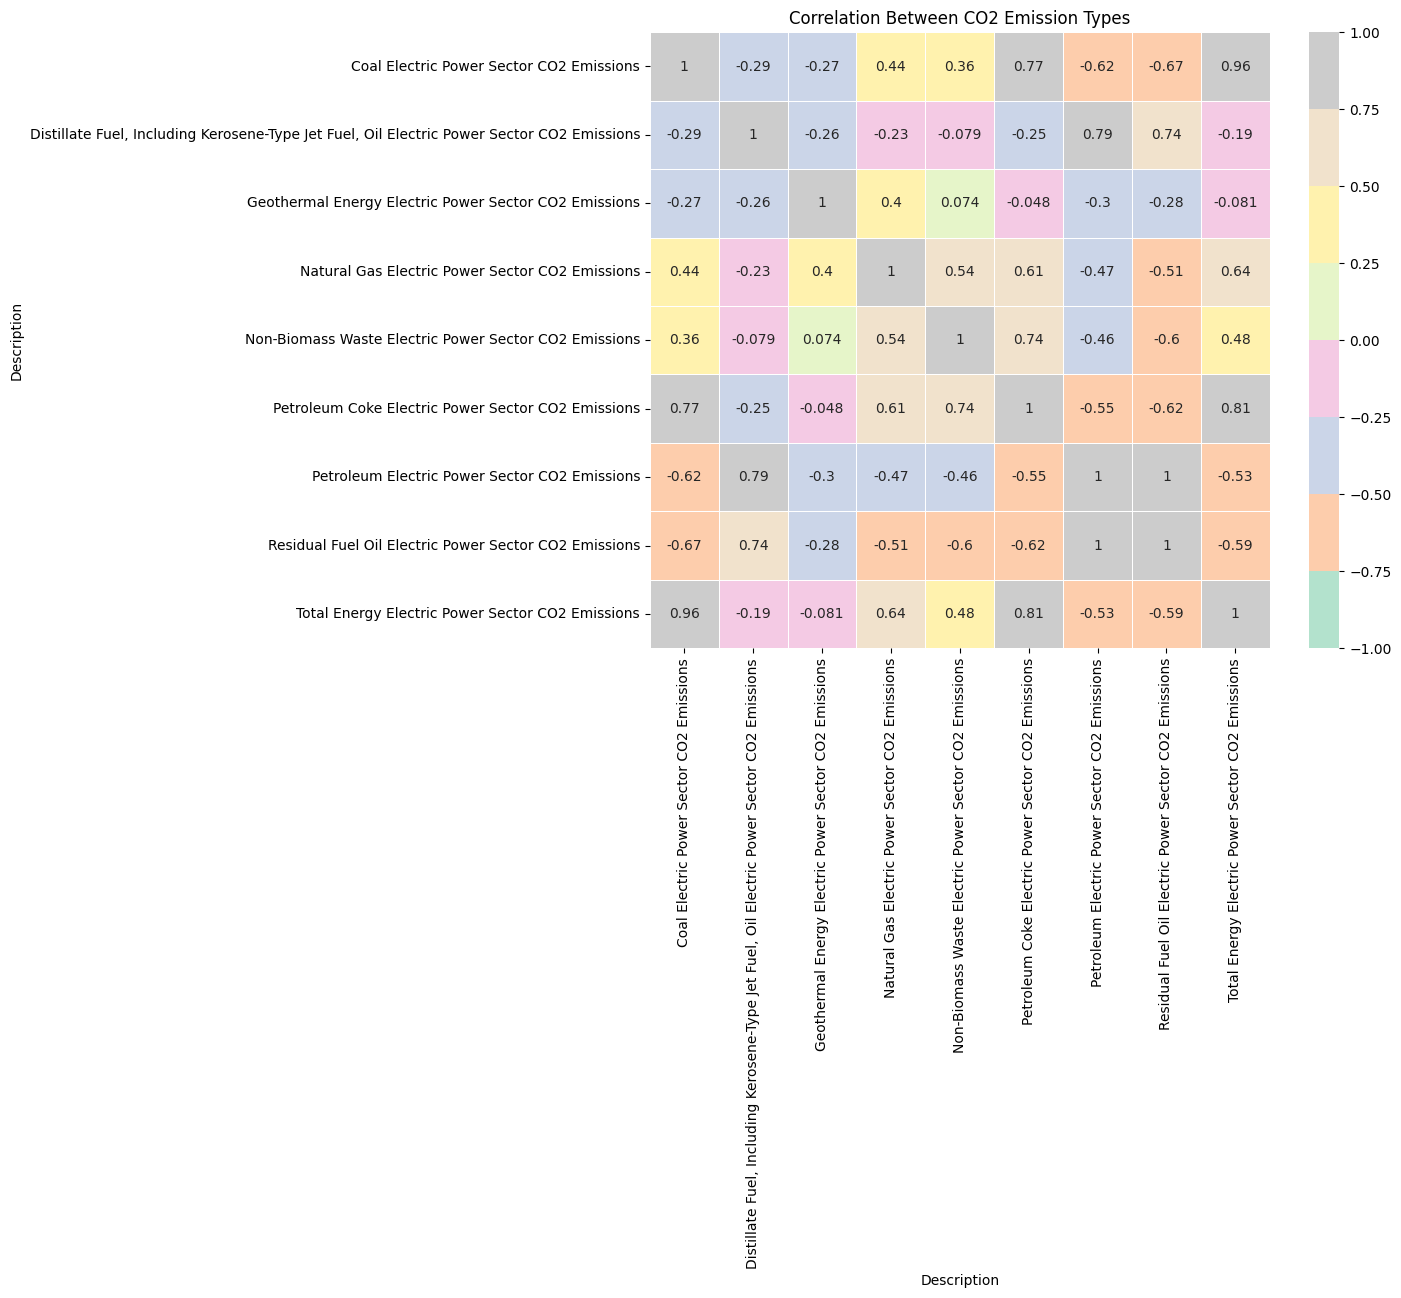

In [25]:
correlation_matrix = pivot_table.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,      # Show correlation values
    cmap='Pastel2',   # Red-Blue color scale
    vmin=-1, vmax=1, # Fix scale from -1 to 1
    linewidths=0.5
)
plt.title("Correlation Between CO2 Emission Types")
plt.show()

In [26]:
ts.isna().sum()

MSN             0
Value           0
Column_Order    0
Description     0
Unit            0
msn_encoded     0
dtype: int64

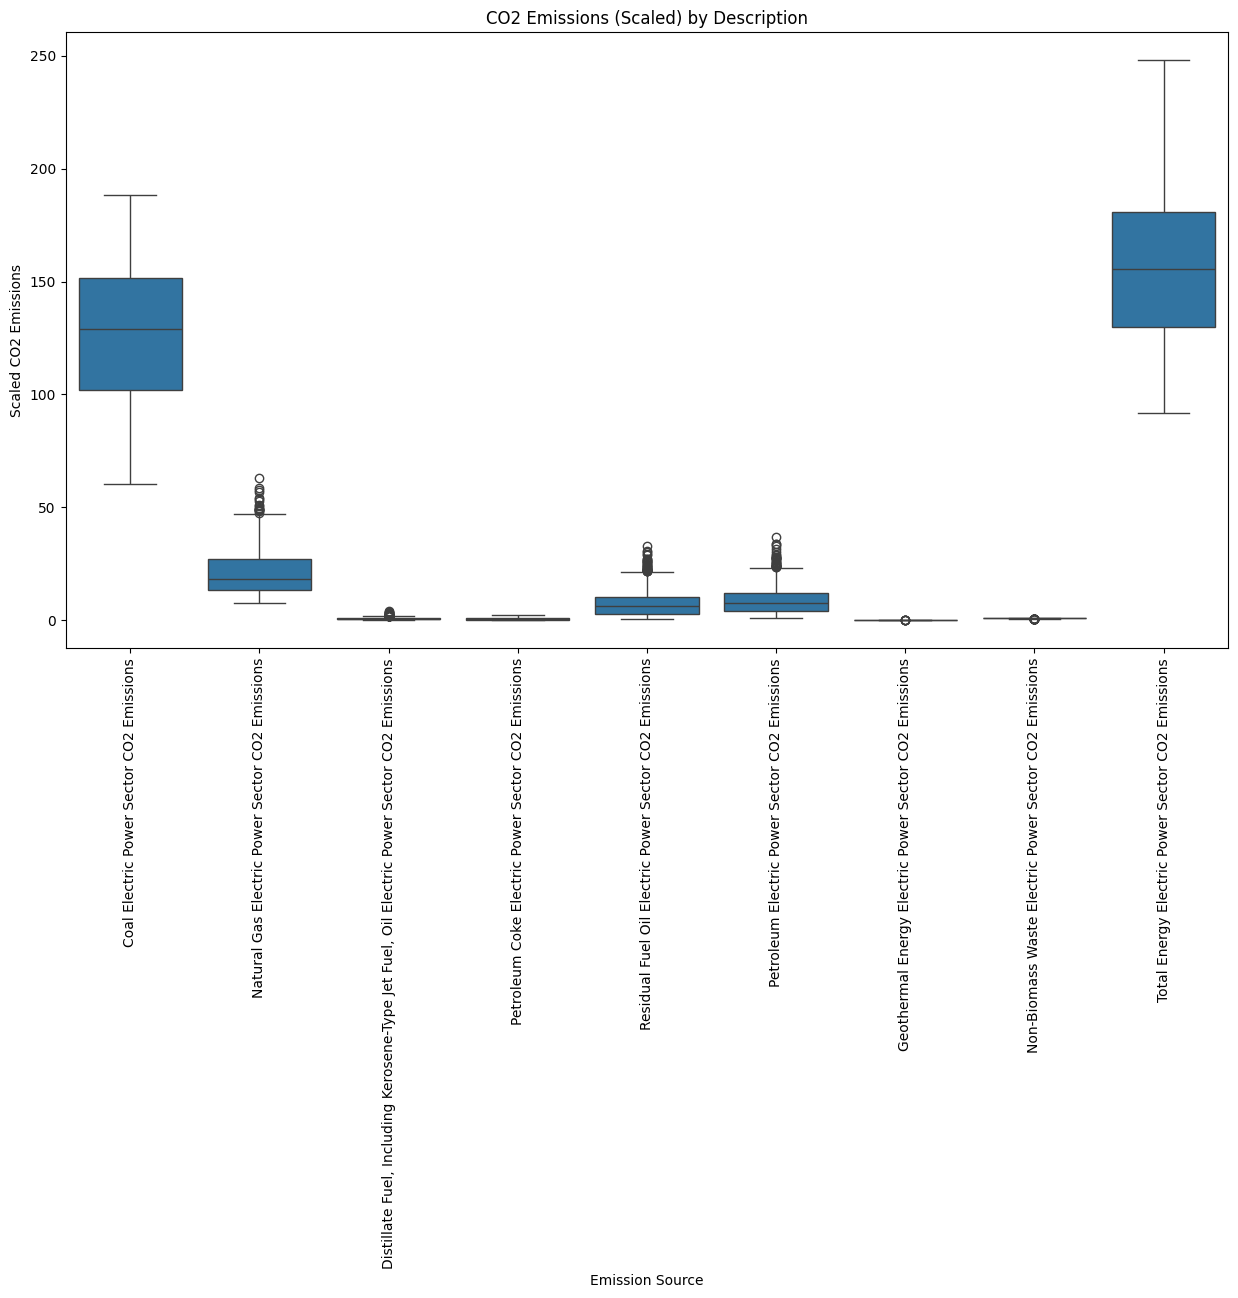

In [27]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='Description', y='Value', data=ts)
plt.xticks(rotation=90)
plt.title('CO2 Emissions (Scaled) by Description')
plt.xlabel('Emission Source')
plt.ylabel('Scaled CO2 Emissions')
plt.show()

# Prétraitement des données : 

In [28]:
ts.describe()

Value  Column_Order  msn_encoded
count  4323.000000   4323.000000  4323.000000
mean     39.252449      4.777932     4.088827
std      61.128676      2.575595     2.659876
min       0.009000      1.000000     0.000000
25%       0.730000      3.000000     2.000000
50%       6.236000      5.000000     4.000000
75%      40.638000      7.000000     6.000000
max     247.995000      9.000000     8.000000

In [29]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ts["Scaled_CO2"] = scaler.fit_transform(ts[["Value"]])
ts

MSN    Value  Column_Order  \
YYYYMM                                       
1973-01-01  CLEIEUS   72.076             1   
1973-02-01  CLEIEUS   64.442             1   
1973-03-01  CLEIEUS   64.084             1   
1973-04-01  CLEIEUS   60.842             1   
1973-05-01  CLEIEUS   61.798             1   
...             ...      ...           ...   
2016-03-01  TXEIEUS  115.997             9   
2016-04-01  TXEIEUS  113.815             9   
2016-05-01  TXEIEUS  129.440             9   
2016-06-01  TXEIEUS  172.074             9   
2016-07-01  TXEIEUS  201.958             9   

                                                 Description  \
YYYYMM                                                         
1973-01-01          Coal Electric Power Sector CO2 Emissions   
1973-02-01          Coal Electric Power Sector CO2 Emissions   
1973-03-01          Coal Electric Power Sector CO2 Emissions   
1973-04-01          Coal Electric Power Sector CO2 Emissions   
1973-05-01          Coal Electric Power Sector CO2 Emissions   
...                                                      ...   
2016-03-01  Total Energy Electric Power Sector CO2 Emissions   
2016-04-01  Total Energy Electric Power Sector CO2 Emissions   
2016-05-01  Total Energy Electric Power Sector CO2 Emissions   
2016-06-01  Total Energy Electric Power Sector CO2 Emissions   
2016-07-01  Total Energy Electric Power Sector CO2 Emissions   

                                             Unit  msn_encoded  Scaled_CO2  
YYYYMM                                                                      
1973-01-01  Million Metric Tons of Carbon Dioxide            0    0.290609  
1973-02-01  Million Metric Tons of Carbon Dioxide            0    0.259825  
1973-03-01  Million Metric Tons of Carbon Dioxide            0    0.258382  
1973-04-01  Million Metric Tons of Carbon Dioxide            0    0.245308  
1973-05-01  Million Metric Tons of Carbon Dioxide            0    0.249163  
...                                           ...          ...         ...  
2016-03-01  Million Metric Tons of Carbon Dioxide            8    0.467720  
2016-04-01  Million Metric Tons of Carbon Dioxide            8    0.458921  
2016-05-01  Million Metric Tons of Carbon Dioxide            8    0.521929  
2016-06-01  Million Metric Tons of Carbon Dioxide            8    0.693850  
2016-07-01  Million Metric Tons of Carbon Dioxide            8    0.814356  

[4323 rows x 7 columns]

In [30]:
Emissions = ts.iloc[:, 1:]
Emissions = (
    Emissions
    .groupby(['Description', pd.Grouper(freq='M')])['Value']
    .sum()
    .unstack(level=0)
)

# Grab the emissions series you're interested in
mte = Emissions['Total Energy Electric Power Sector CO2 Emissions']
real_mte = mte
mte

YYYYMM
1973-01-31    111.621
1973-02-28     99.185
1973-03-31     99.112
1973-04-30     93.183
1973-05-31     98.012
               ...   
2016-03-31    115.997
2016-04-30    113.815
2016-05-31    129.440
2016-06-30    172.074
2016-07-31    201.958
Freq: ME, Name: Total Energy Electric Power Sector CO2 Emissions, Length: 523, dtype: float64

In [31]:
real_mte.describe()

count    523.000000
mean     157.462096
std       33.908393
min       91.834000
25%      129.736000
50%      155.571000
75%      180.920000
max      247.995000
Name: Total Energy Electric Power Sector CO2 Emissions, dtype: float64

In [32]:
Emissions_ = ts.iloc[:, 1:]
Emissions_ = (
    Emissions_
    .groupby(['Description', pd.Grouper(freq='M')])['Scaled_CO2']
    .sum()
    .unstack(level=0)
)

# Grab the emissions series you're interested in
mte_ = Emissions_['Total Energy Electric Power Sector CO2 Emissions']
mte_

YYYYMM
1973-01-31    0.450074
1973-02-28    0.399926
1973-03-31    0.399631
1973-04-30    0.375723
1973-05-31    0.395196
                ...   
2016-03-31    0.467720
2016-04-30    0.458921
2016-05-31    0.521929
2016-06-30    0.693850
2016-07-31    0.814356
Freq: ME, Name: Total Energy Electric Power Sector CO2 Emissions, Length: 523, dtype: float64

# Echantillonnage  des  données

In [33]:
tscv = TimeSeriesSplit(n_splits=10)

# Application  des  modèles  d’apprentissage  profond  en  se  basant  sur  les  séries temporelles

## LSTM

In [34]:
train_size_lstm = int(0.7 * len(mte_))
test_size_lstm = len(mte_) - train_size_lstm

train_lstm = mte_.iloc[:train_size_lstm]
test_lstm = mte_.iloc[train_size_lstm:]

In [35]:
# Trouver la dernière date du dataset complet
last_date = pd.concat([train_lstm, test_lstm]).index[-1]

# Créer un index de dates pour l'année suivante (12 mois)
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                            periods=12, 
                            freq='M')

In [36]:
# Préparation des données pour LSTM
X, y = [], []
for i in range(60, len(train_lstm)):
    X.append(train_lstm.values[i-60:i])
    y.append(train_lstm.values[i])
X, y = np.array(X), np.array(y)

# Reshape pour LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))


In [37]:
# Validation croisée pour LSTM
mse_lstm_scores = []
rmse_lstm_scores = []
mae_lstm_scores = []
r2_lstm_scores = []


for train_index, val_index in tscv.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]
    
    # Création du modèle LSTM
    model_lstm = Sequential()
    model_lstm.add(LSTM(64, input_shape=(X_train_cv.shape[1], 1)))
    # model_lstm.add(Dropout(0.4)),
    model_lstm.add(Dense(1))
    
    # Compilation et entraînement
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    model_lstm.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, verbose=0)
    
    # Prédictions
    predictions_lstm = model_lstm.predict(X_val_cv)
    predictions_lstm_inverse = scaler.inverse_transform(predictions_lstm)
    y_val_cv_inverse = scaler.inverse_transform(y_val_cv.reshape(-1, 1))

    mse_lstm = mean_squared_error(y_val_cv_inverse, predictions_lstm_inverse)
    mse_lstm_scores.append(mse_lstm)

    rmse_lstm = np.sqrt(mse_lstm)
    rmse_lstm_scores.append(rmse_lstm)
    mae_lstm = mean_absolute_error(y_val_cv_inverse, predictions_lstm_inverse)
    mae_lstm_scores.append(mae_lstm)
    r2_lstm = r2_score(y_val_cv_inverse, predictions_lstm_inverse)
    r2_lstm_scores.append(r2_lstm)

# Affichage des résultats de validation croisée pour LSTM
print(f'MSE moyen LSTM: {np.mean(mse_lstm_scores)}')
print(f'RMSE moyen LSTM: {np.mean(rmse_lstm_scores)}')
print(f'MAE moyen LSTM: {np.mean(mae_lstm_scores)}')
print(f'R2 moyen LSTM: {np.mean(r2_lstm_scores)}')


2025-04-30 23:07:19.248727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-30 23:07:19.262191: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 [==============================] - 0s 224ms/step
MSE moyen LSTM: 305.5515533104861
RMSE moyen LSTM: 17.13415561648558
MAE moyen LSTM: 13.33718390661169
R2 moyen LSTM: -0.16679413222618825


In [38]:
# Re-prepare test data for LSTM (using the same 60 timesteps sliding window)
X_test_final, y_test_final = [], []
for i in range(60, len(test_lstm)):
    X_test_final.append(test_lstm.values[i-60:i])
    y_test_final.append(test_lstm.values[i])
X_test_final, y_test_final = np.array(X_test_final), np.array(y_test_final)

# Reshape for LSTM input
X_test_final = X_test_final.reshape((X_test_final.shape[0], X_test_final.shape[1], 1))

# Train final LSTM model
model_lstm_final = Sequential()
model_lstm_final.add(LSTM(64, input_shape=(X.shape[1], 1)))  # X.shape[1] = 60 steps
model_lstm_final.add(Dense(1))
model_lstm_final.compile(optimizer='adam', loss='mean_squared_error')

lstm_par = model_lstm_final.count_params()

# Fit on FULL train set (X, y) prepared earlier
start_train = time.time()
model_lstm_final.fit(X, y, epochs=50, batch_size=32, verbose=0)
end_train = time.time()
training_time_lstm = end_train - start_train

# Predict on test set
start_inference = time.time()
predictions_lstm_final = model_lstm_final.predict(X_test_final)
end_inference = time.time()
inference_time_lstm = end_inference - start_inference

# Inverse scaling (if you want real units)
predictions_lstm_final_inverse = scaler.inverse_transform(predictions_lstm_final)
y_test_final_inverse = scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Evaluation
mse_test_lstm = mean_squared_error(y_test_final_inverse, predictions_lstm_final_inverse)
rmse_test_lstm = np.sqrt(mean_squared_error(y_test_final_inverse, predictions_lstm_final_inverse))
mae_test_lstm = mean_absolute_error(y_test_final_inverse, predictions_lstm_final_inverse)
r2_test_lstm = r2_score(y_test_final_inverse, predictions_lstm_final_inverse)

# ==== 1. Préparation des données pour la prévision ====
# Nous avons besoin des 60 dernières valeurs pour faire la première prédiction
last_60 = test_lstm.values[-60:].reshape(1, 60, 1)  # Format (1, 60, 1) pour LSTM

# ==== 2. Boucle de prévision ====
forecasts = []
for _ in range(12):  # Prévision pour 12 mois
    # Prédire le prochain pas de temps
    next_pred = model_lstm_final.predict(last_60, verbose=0)
    forecasts.append(next_pred[0,0])
    
    # Mettre à jour la fenêtre glissante
    last_60 = np.roll(last_60, -1, axis=1)
    last_60[0, -1, 0] = next_pred[0,0]

# ==== 3. Post-traitement ====
# Inverse scaling si nécessaire
forecasts = np.array(forecasts).reshape(-1, 1)
forecasts_inverse = scaler.inverse_transform(forecasts)

print(f'LSTM - MSE Test: {mse_test_lstm:.4f}, RMSE Test: {rmse_test_lstm}, MAE Test: {mae_test_lstm:.4f}, R² Test: {r2_test_lstm:.4f}, Training Time: {training_time_lstm}, Inference Time: {inference_time_lstm}, Parameters: {lstm_par}')


4/4 [==============================] - 0s 6ms/step
LSTM - MSE Test: 583.6478, RMSE Test: 24.15880459605479, MAE Test: 20.5982, R² Test: 0.1279, Training Time: 9.451507806777954, Inference Time: 0.28008294105529785, Parameters: 16961


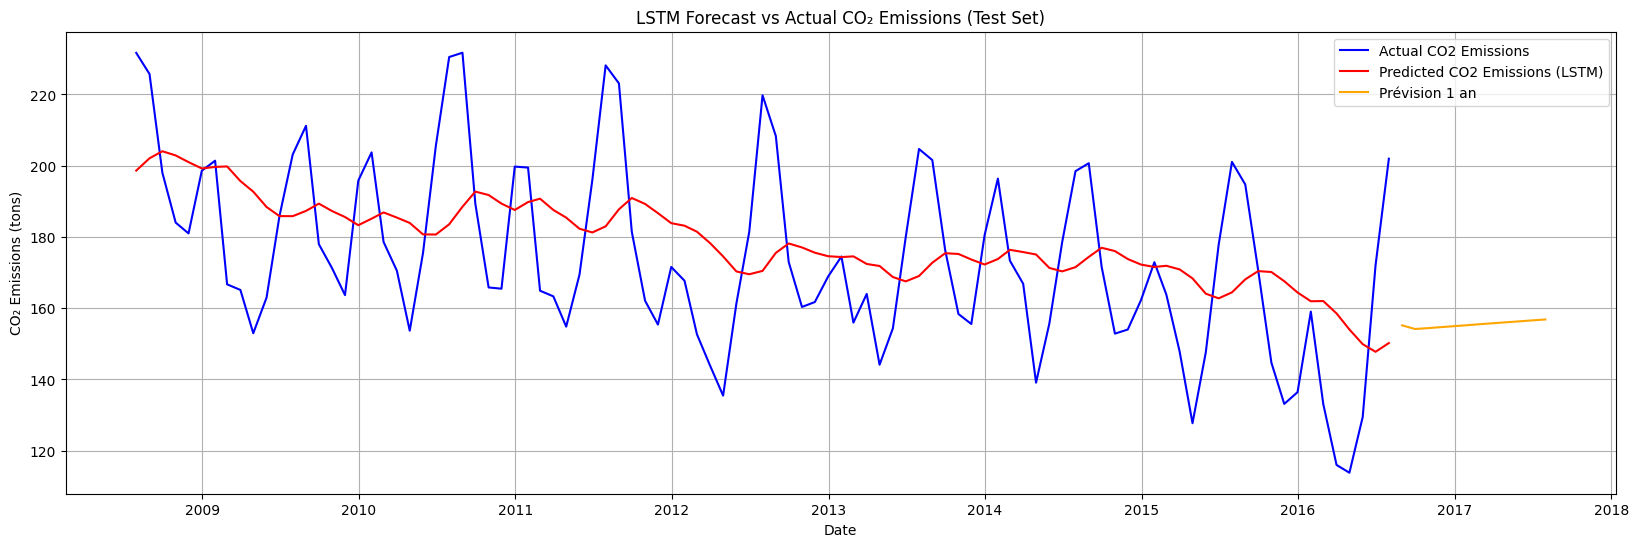

In [39]:
test_index = test_lstm.index[60:]  # because we lose 60 first steps in sliding window

# Plot
plt.figure(figsize=(20, 6))
plt.plot(test_index, y_test_final_inverse, label="Actual CO2 Emissions", color='blue')
plt.plot(test_index, predictions_lstm_final_inverse, label="Predicted CO2 Emissions (LSTM)", color='red')
plt.plot(future_dates, forecasts_inverse, label='Prévision 1 an', color='orange')
plt.legend()
plt.title("LSTM Forecast vs Actual CO₂ Emissions (Test Set)")
plt.xlabel("Date")
plt.ylabel("CO₂ Emissions (tons)")
plt.grid(True)
plt.show()

## Transformer

In [40]:
train = mte[mte.index.year < 2010]
test = mte[mte.index.year >= 2000]

# Scale the specific series
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train.values.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test.values.reshape(-1, 1)).flatten()

In [41]:
# 3. Sequence Preparation
# ----------------------
SEQUENCE_SIZE = 12  # Using 2 years of monthly data as context

def to_sequences(seq_size, obs):
    x, y = [], []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, train_scaled)
x_test, y_test = to_sequences(SEQUENCE_SIZE, test_scaled)

# Create DataLoaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
# 4. Transformer Model (same as before)
# ------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [43]:
class CO2Transformer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=3, dropout=0.4):
        super(CO2Transformer, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Transformer encoder with correct settings
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True  # Critical for correct dimensions
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
            )
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.encoder(x)  # (batch_size, seq_len, d_model)
        
        # Positional encoding expects (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)  # Change to (seq_len, batch_size, d_model)
        x = self.pos_encoder(x)
        
        # Transformer expects (batch_size, seq_len, d_model) when batch_first=True
        x = x.permute(1, 0, 2)  # Change back to (batch_size, seq_len, d_model)
        x = self.transformer_encoder(x)
        
        # Use only last time step's output
        x = self.decoder(x[:, -1, :])  # (batch_size, 1)
        return x

In [44]:
# 5. Training Setup
# ----------------
model = CO2Transformer().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [45]:
# 6. Training Loop
# ---------------
epochs = 200
best_val_loss = float('inf')
early_stop_counter = 0
patience = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            val_loss += criterion(model(x_batch), y_batch).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_co2_transformer.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/200, Train Loss: 0.4442, Val Loss: 0.3288
Epoch 2/200, Train Loss: 0.3327, Val Loss: 0.4812
Epoch 3/200, Train Loss: 0.2982, Val Loss: 0.2880
Epoch 4/200, Train Loss: 0.2454, Val Loss: 0.3869
Epoch 5/200, Train Loss: 0.2346, Val Loss: 0.2565
Epoch 6/200, Train Loss: 0.2338, Val Loss: 0.3860
Epoch 7/200, Train Loss: 0.2092, Val Loss: 0.2114
Epoch 8/200, Train Loss: 0.2376, Val Loss: 0.1217
Epoch 9/200, Train Loss: 0.2025, Val Loss: 0.1312
Epoch 10/200, Train Loss: 0.1749, Val Loss: 0.3596
Epoch 11/200, Train Loss: 0.1977, Val Loss: 0.2729
Epoch 12/200, Train Loss: 0.1635, Val Loss: 0.1227
Epoch 13/200, Train Loss: 0.1930, Val Loss: 0.2847
Epoch 14/200, Train Loss: 0.1681, Val Loss: 0.2466
Epoch 15/200, Train Loss: 0.1629, Val Loss: 0.2175
Epoch 16/200, Train Loss: 0.1524, Val Loss: 0.2005
Epoch 17/200, Train Loss: 0.1412, Val Loss: 0.1597
Epoch 18/200, Train Loss: 0.1590, Val Loss: 0.1052
Epoch 19/200, Train Loss: 0.1483, Val Loss: 0.1277
Epoch 20/200, Train Loss: 0.1559, Val Lo

In [46]:
# Evaluation
start_train = time.time()
model.eval()
end_train = time.time()
training_time_trans = end_train - start_train

predictions = []

start_inference = time.time()
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())
end_inference = time.time()
inference_time_trans = end_inference - start_inference

# Inverse scaling
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

mse_test_trans = np.mean((predictions- actuals)**2)
rmse_test_trans = np.sqrt(np.mean((predictions- actuals)**2))
mae_test_trans = mean_absolute_error(actuals, predictions)
r2_test_trans = r2_score(actuals, predictions)

trans_par = sum(p.numel() for p in model.parameters())
print(f"Score (MSE): {mse_test_trans:.4f}, Score (RMSE): {rmse_test_trans:.4f}, Score (MAE): {mae_test_trans:.4f}, Score (R2): {r2_test_trans:.4f}, Training Time: {training_time_trans:.4f}, Inference Time: {inference_time_trans:.4f}, Parameters: {trans_par}")

Score (MSE): 268.3393, Score (RMSE): 16.3811, Score (MAE): 13.7658, Score (R2): 0.5877, Training Time: 0.0002, Inference Time: 0.0164, Parameters: 847809


In [47]:
# 7. Evaluation and Forecasting
# ----------------------------
model.load_state_dict(torch.load('best_co2_transformer.pth'))
model.eval()

# Evaluate on test set
predictions = []
actuals = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        outputs = model(x_batch.to(device))
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.numpy())

# Inverse scaling
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"\nTest Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")


Test Metrics:
MSE: 114.61
RMSE: 10.71
MAE: 8.19
R²: 0.8239


In [48]:
def forecast(model, last_sequence, steps=12):
    model.eval()
    forecasts = []
    
    # Ensure correct input dimensions (batch_size=1, seq_len, features=1)
    current_seq = last_sequence.to(device)  # Add batch dimension
    
    with torch.no_grad():
        for _ in range(steps):
            pred = model(current_seq)
            forecasts.append(pred.item())
            
            # Update sequence: remove oldest, add new prediction
            current_seq = torch.cat([
                current_seq[:, 1:, :],  # Remove oldest (batch_size, seq_len-1, 1)
                pred.unsqueeze(1)       # Add new prediction (batch_size, 1, 1)
            ], dim=1)
    
    return np.array(forecasts)

In [49]:
# Generate forecast
last_seq = x_test[-1].unsqueeze(0)
forecast_scaled = forecast(model, last_seq)
forecast_values = scaler.inverse_transform(forecast_scaled.reshape(-1, 1))

# Create future dates
last_date = test.index[-1]
future_dates = pd.date_range(start=last_date , periods=12, freq='M')

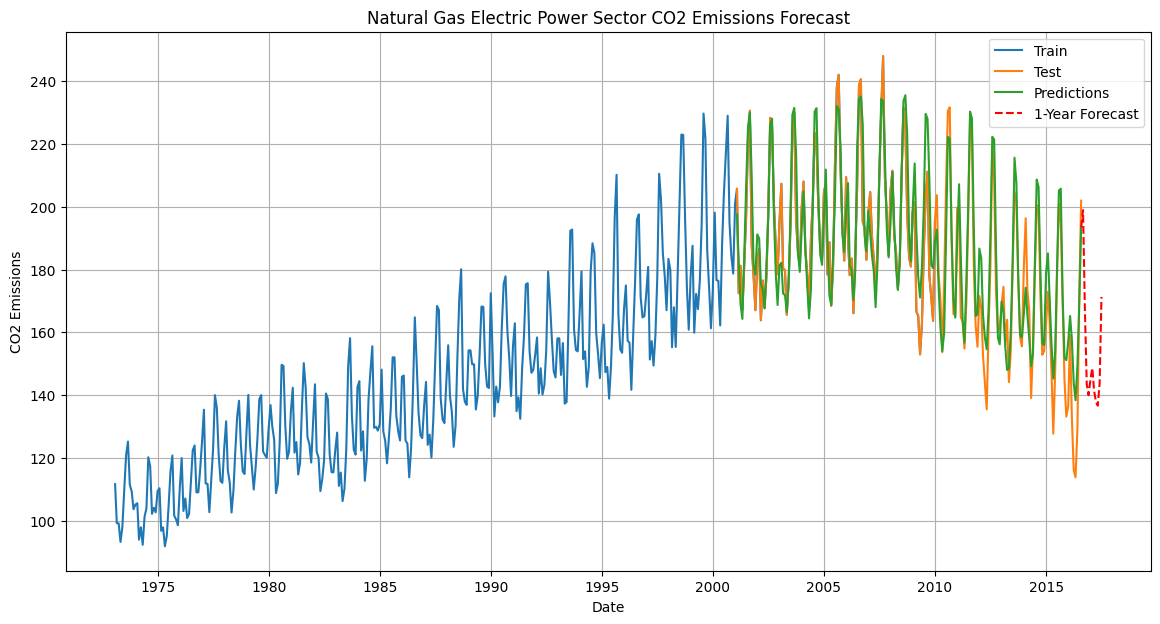

In [50]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train.index, scaler.inverse_transform(train_scaled.reshape(-1, 1)), label='Train')
plt.plot(test.index[SEQUENCE_SIZE:], actuals, label='Test')
plt.plot(test.index[SEQUENCE_SIZE:], predictions, label='Predictions')
plt.plot(future_dates, forecast_values, 'r--', label='1-Year Forecast')
plt.title('Natural Gas Electric Power Sector CO2 Emissions Forecast')
plt.xlabel('Date')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid()
plt.show()

## ARIMA & Seasonal ARIMA

### Stationary Test

We are going to test is our data is stationary

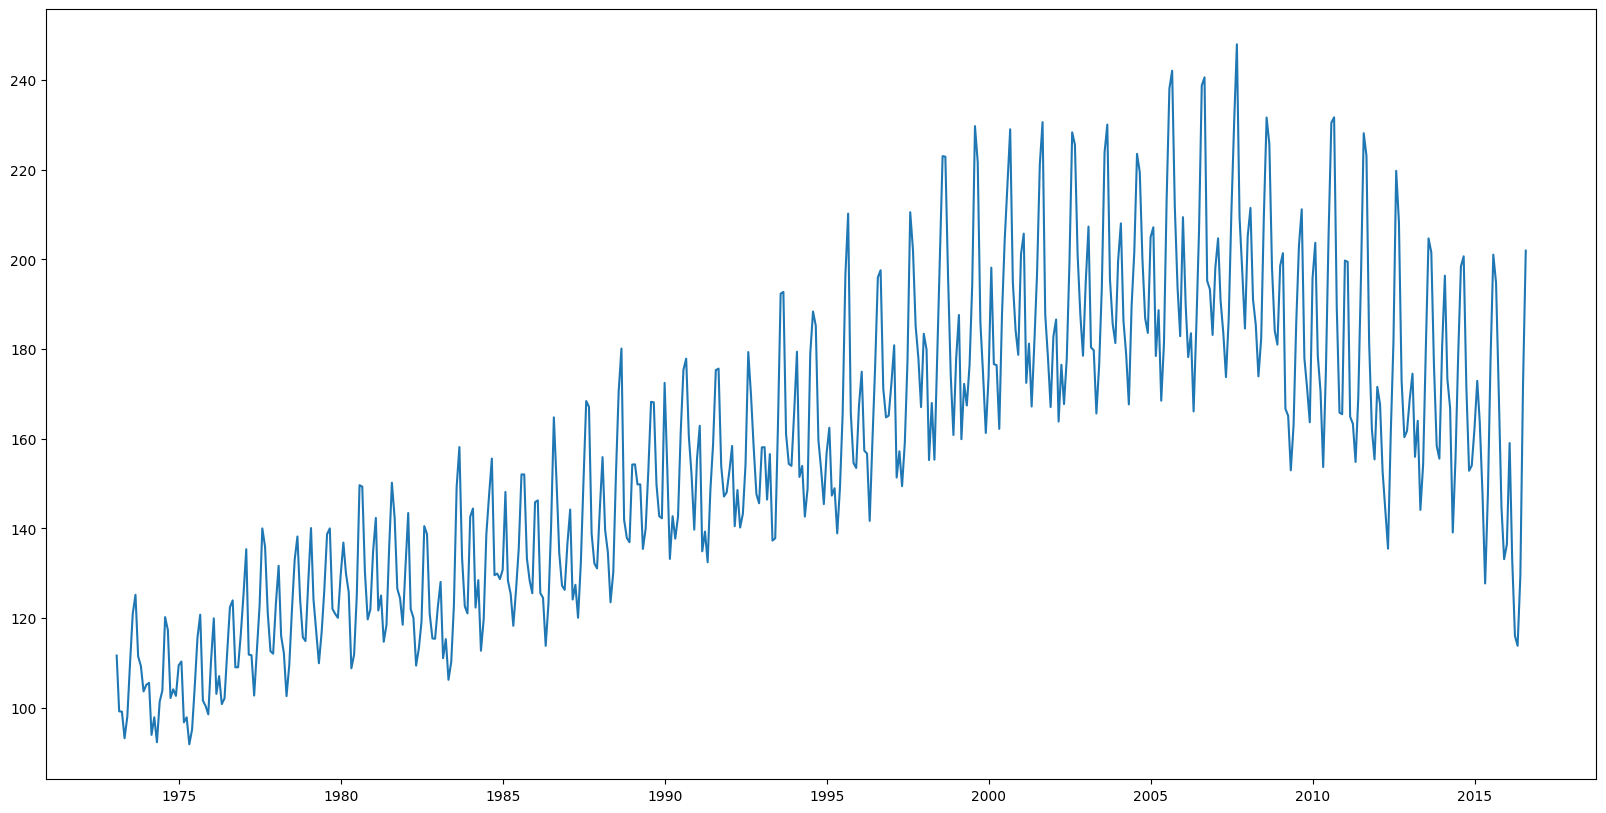

In [51]:
plt.figure(figsize=(20, 10))
plt.plot(mte)

From the figures, it is evident that there is a trend in the CO2 emission dataset with seasonal variation. So, we can infer a concluding remark that the dataset is not stationary.

But for more formality we will use Dicky-Fuller

In [52]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.figure(figsize=(20, 10))
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Time in Years', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)

In [53]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

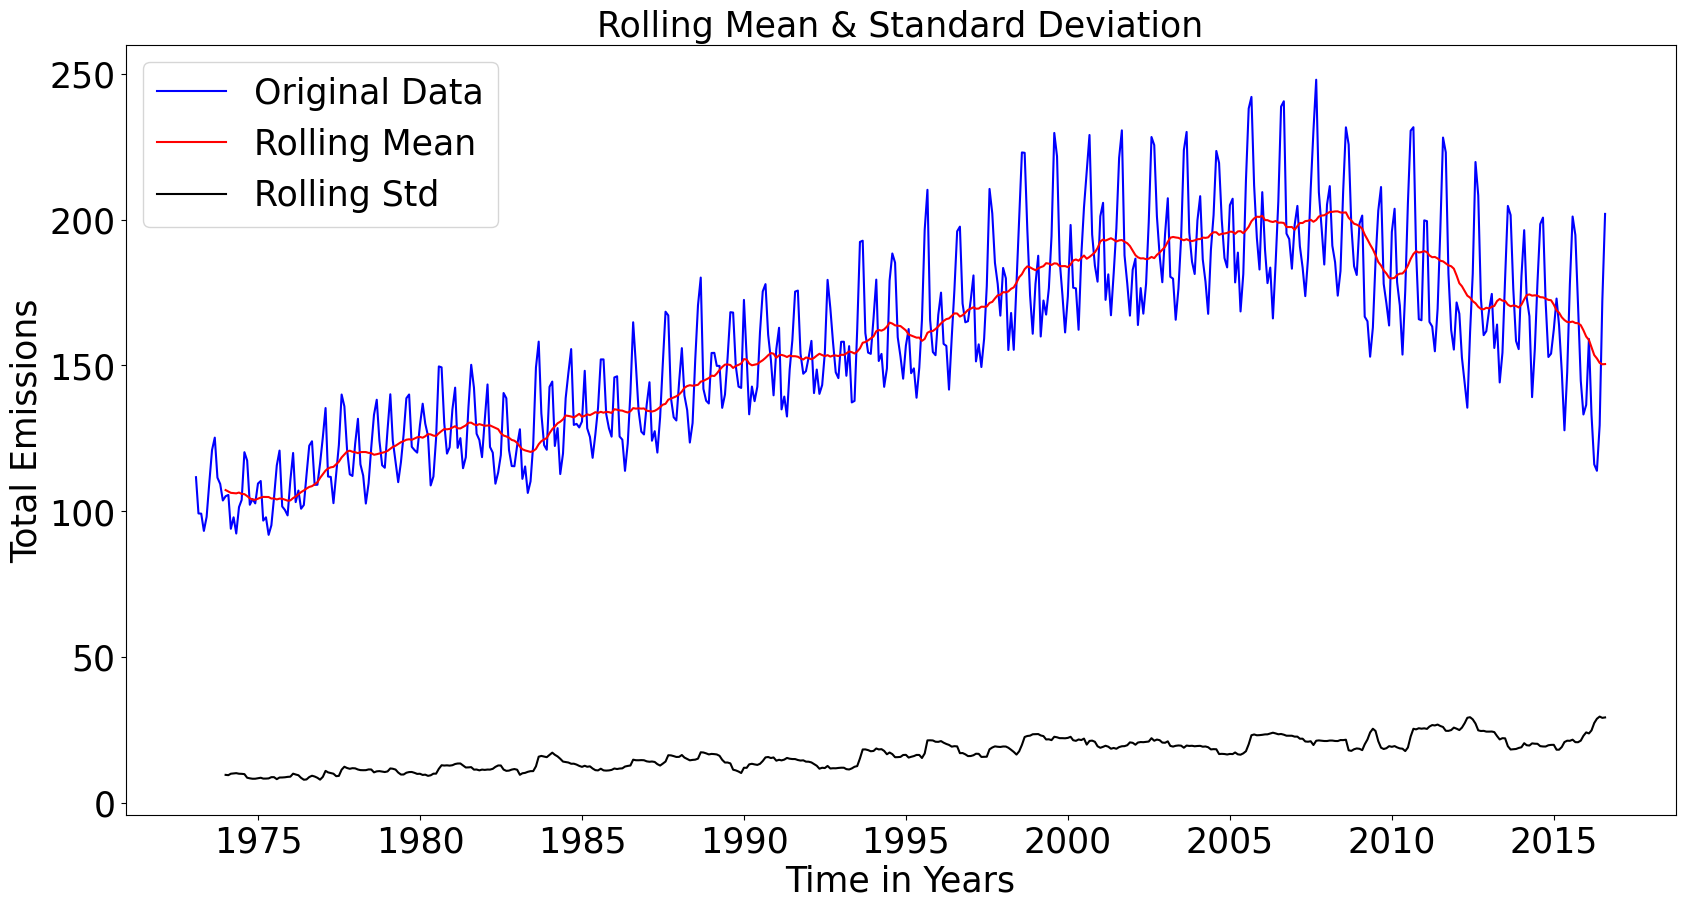

In [54]:
TestStationaryPlot(mte)

In [55]:
TestStationaryAdfuller(mte)

Test Statistic                  -1.809627
p-value                          0.375693
#Lags Used                      14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


The emissions mean and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary. Also, the Test Statistic is greater than the critical values with 90%, 95% and 99% confidence levels. Hence, no evidence to reject the null hypothesis. Therefore the series is nonstationary. 

Since our data is not stationary we have to transform it now

The most common techniques used to estimate or model trend and then remove it from the time series are 
- Aggregation – taking average for a time period like monthly/weekly average
- Smoothing – taking rolling averages
- Polynomial Fitting – fit a regression model

One of the most common method of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the original observation at a particular instant with that at the previous instant. This mostly works well to improve stationarity. First order differencing can be done as follows:

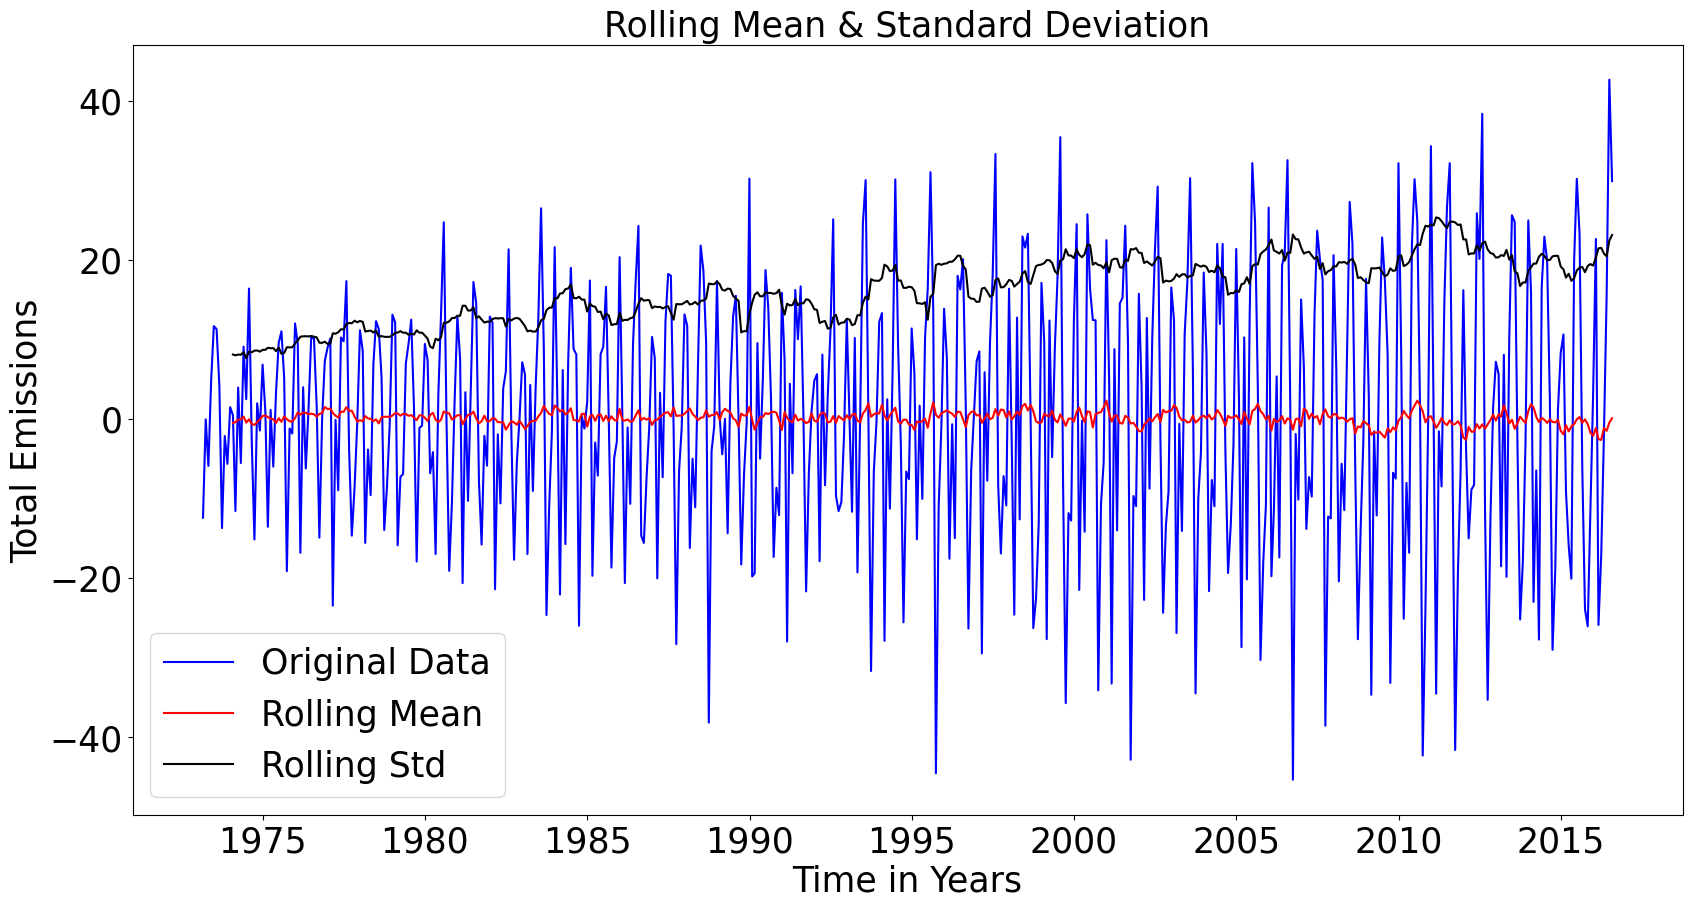

In [56]:
mte_first_difference = mte - mte.shift(1)  
TestStationaryPlot(mte_first_difference.dropna(inplace=False))

In [57]:
TestStationaryAdfuller(mte_first_difference.dropna(inplace=False))

Test Statistic                -6.610275e+00
p-value                        6.402884e-09
#Lags Used                     1.300000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


The first difference improves the stationarity of the series significantly. Let us use also the ***seasonal difference*** to remove the seasonality of the data and see how that impacts stationarity of the data.

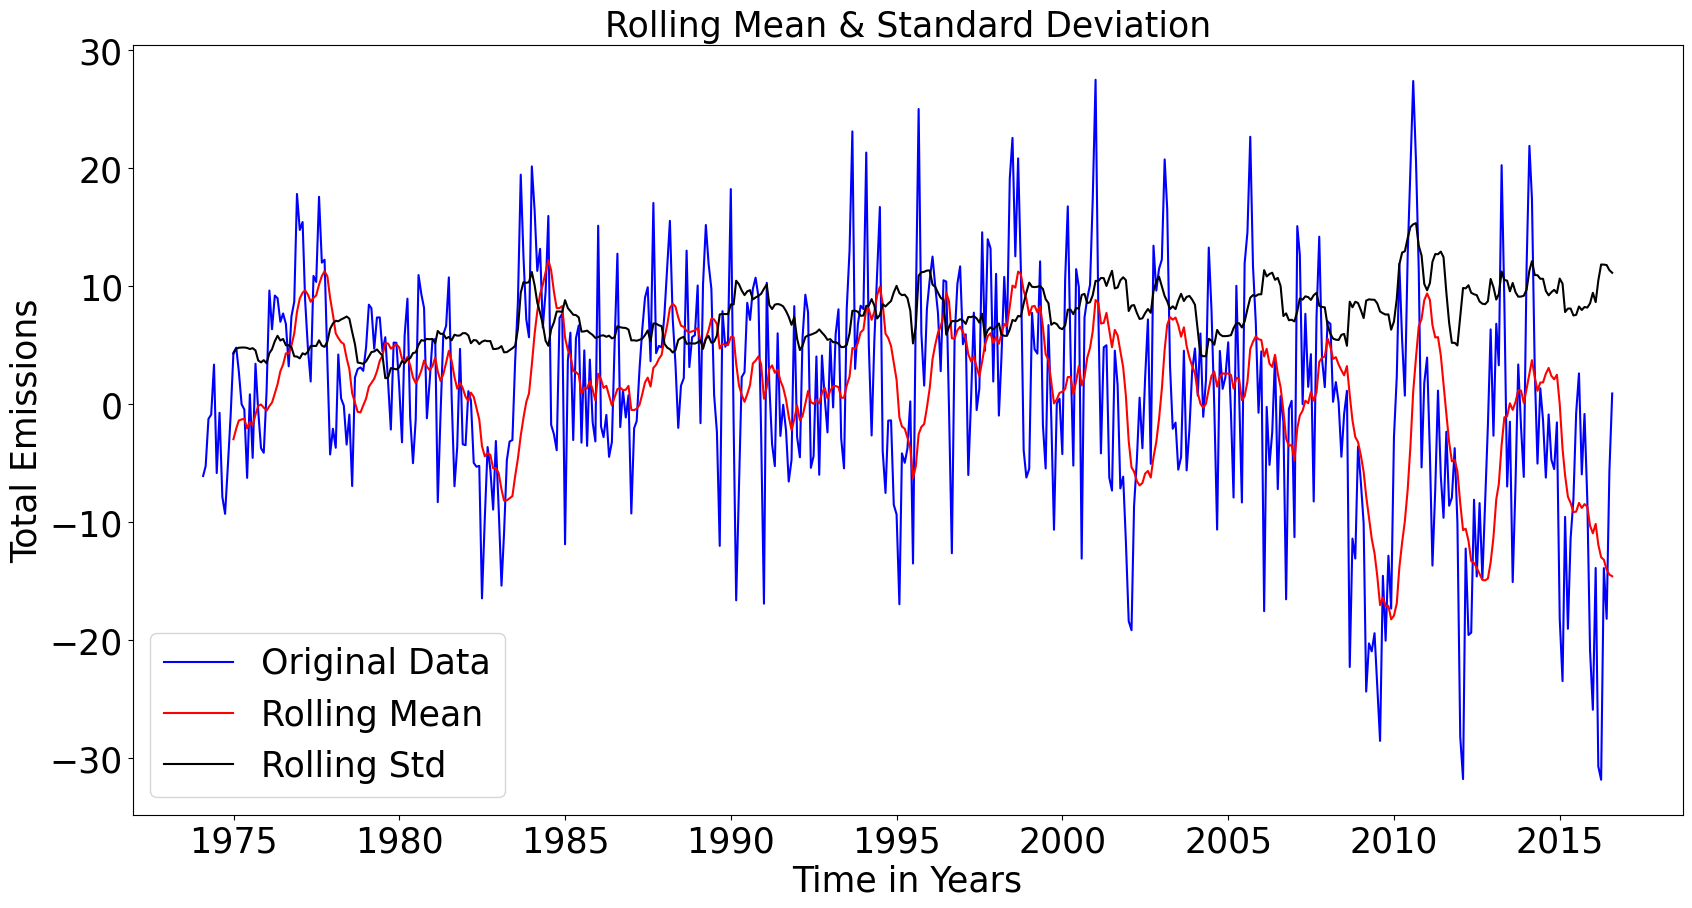

Test Statistic                  -5.495918
p-value                          0.000002
#Lags Used                      12.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [58]:
mte_seasonal_difference = mte - mte.shift(12)  
TestStationaryPlot(mte_seasonal_difference.dropna(inplace=False))
TestStationaryAdfuller(mte_seasonal_difference.dropna(inplace=False))

Compared to the original data the seasonal difference also improves the stationarity of the series. The next step is to take the first difference of the seasonal difference.

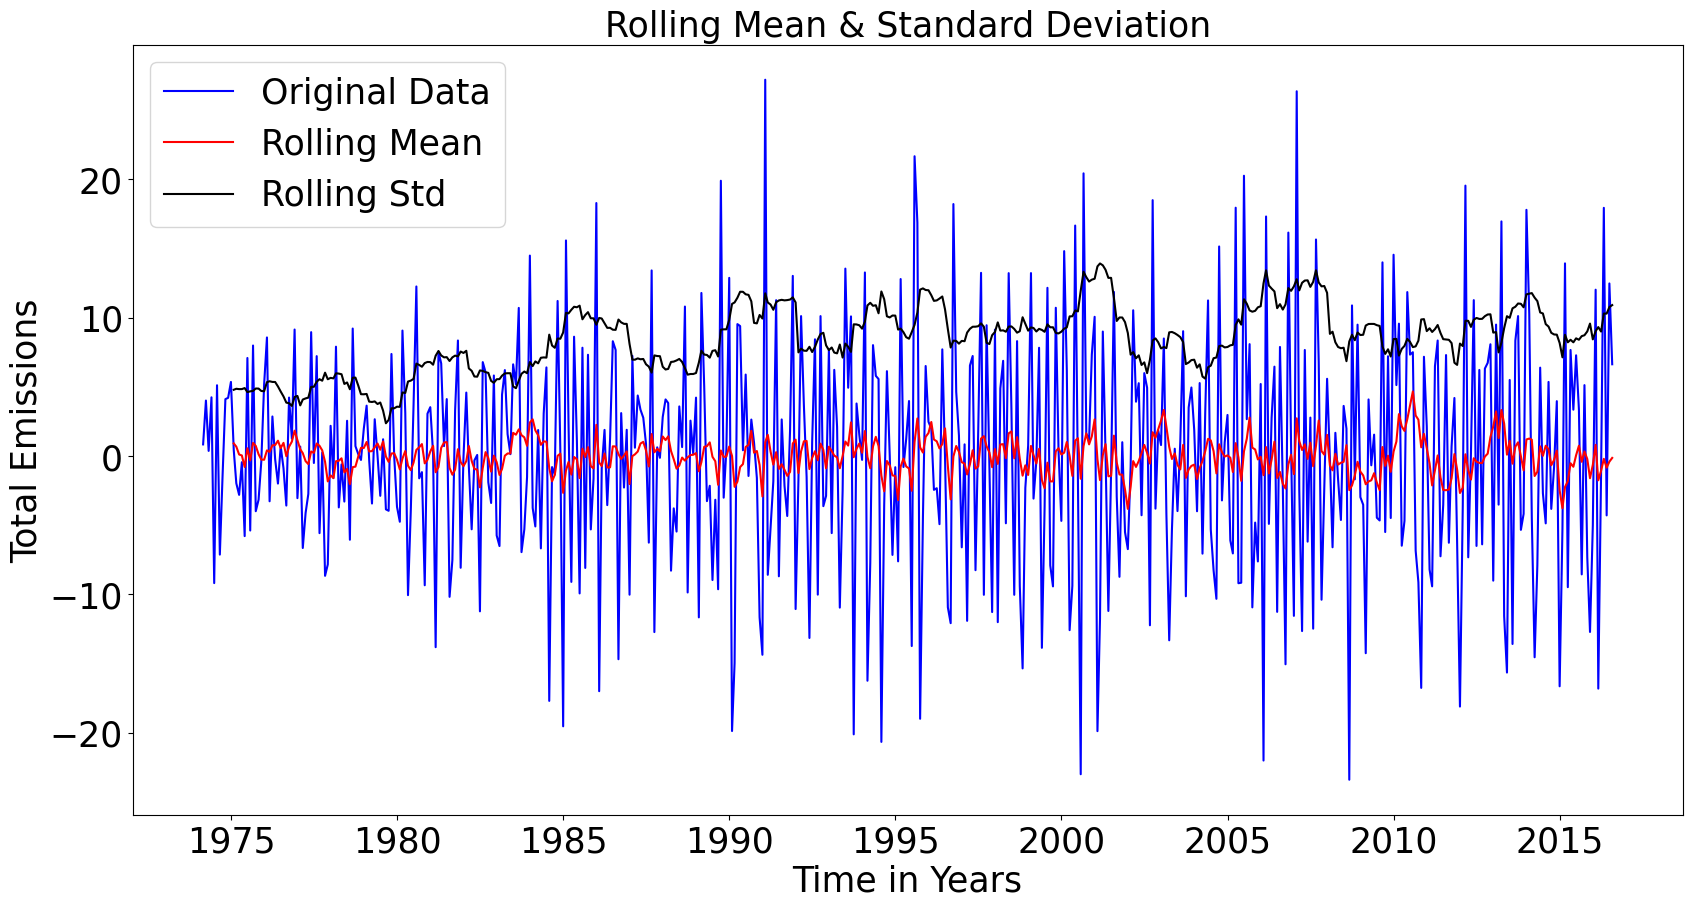

In [59]:
mte_seasonal_first_difference = mte_first_difference - mte_first_difference.shift(12)  
TestStationaryPlot(mte_seasonal_first_difference.dropna(inplace=False))

In [60]:
TestStationaryAdfuller(mte_seasonal_first_difference.dropna(inplace=False))

Test Statistic                -8.574894e+00
p-value                        8.012370e-14
#Lags Used                     1.400000e+01
Number of Observations Used    4.950000e+02
Critical Value (1%)           -3.443630e+00
Critical Value (5%)           -2.867397e+00
Critical Value (10%)          -2.569889e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


Now, if we look the Test Statistic and the p-value, taking the seasonal first difference has made our the time series dataset stationary. This differencing procedure could be repeated for the log values, but it didn’t make the dataset any more stationary.

### Parameters

Now that our data is stationary we will find the optimal parameter for ou ARIMA and SARIMA models:

When looking to fit time series dataset with seasonal ARIMA model, our first goal is to find the values of SARIMA(p,d,q)(P,D,Q)s that optimize our metric of interest. Before moving directly how to find the optimal values of the parameters let us see the two situations in stationarities: A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as **white noise.** The second case being a series with significant dependence among values and needs statistical models like ARIMA to forecast future oucomes.

**Auto-Regressive Integrated Moving Average (ARIMA)**: The ARIMA forecasting for a stationary time series is a linear funcion similar to linear regression. The predictors mainly depend on the parameters (p,d,q) of the ARIMA model:

* Number of **Auto-Regressive (AR) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 4, the predictors for x(t) will depend on x(t-1)….x(t-4).  This term allows us to incorporate the effect of past values into our model. This would be similar to stating that the weather is likely to be warm tomorrow if it has been warm the past 4 days.
* Number of **Moving Average(MA) terms (q)**: MA terms are lagged forecast errors in prediction function. This term allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past. For instance if q is 4, the predictors for x(t) will be e(t-1)….e(t-4) where e(i) is the difference between the moving average at ith instant and actual value.
* Number of** Differences (d)**: These are the number of nonseasonal differences, i.e.,  if we took the first order difference. So either we can pass the first order difference variable and put d=0 or pass the original observed variable and put d=1. Both will generate same results. This term explains the number of past time points to subtract from the current value. This would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

#### Plot the ACF and PACF charts and find the optimal parameters

* **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the time series (ts) with a lagged version of itself. For instance at lag 4, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-4’…’t2-4’ (t1-4 and t2 being end points of the range).
* **Partial Autocorrelation Function (PACF)**: This measures the correlation between the ts with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 4, it will check the correlation but remove the effects already explained by lags 1 to  3.

Therefore, the next step will be determing the tuning parameters (p and q) of the model by looking at the autocorrelation and partial autocorrelation graphs.  The chart below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs inorder to select the parameters. 

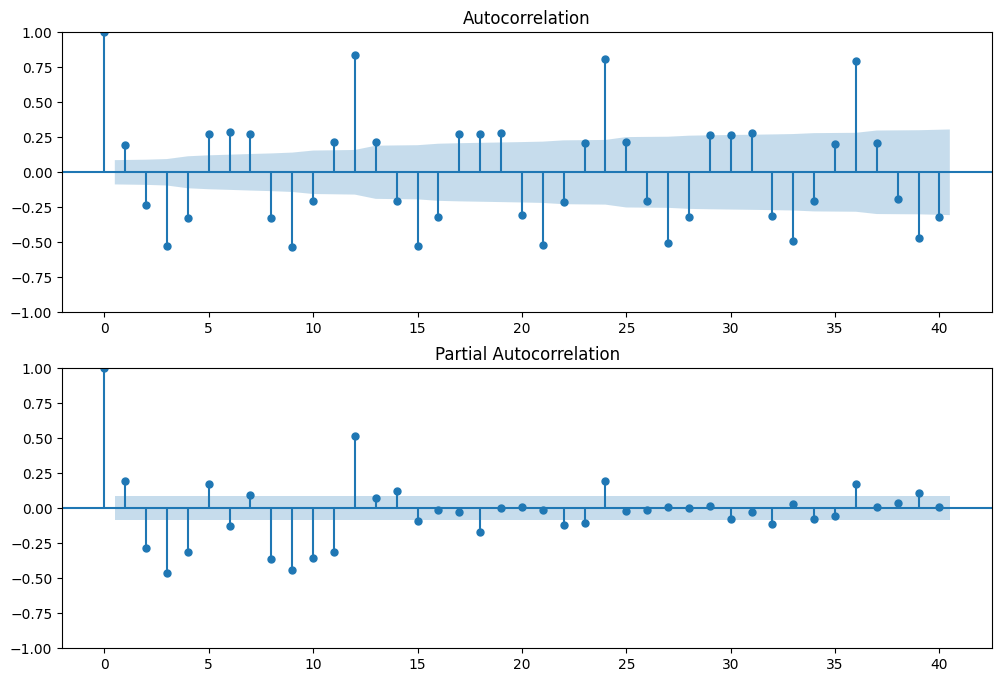

In [61]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_first_difference.iloc[13:], lags=40, ax=ax2)

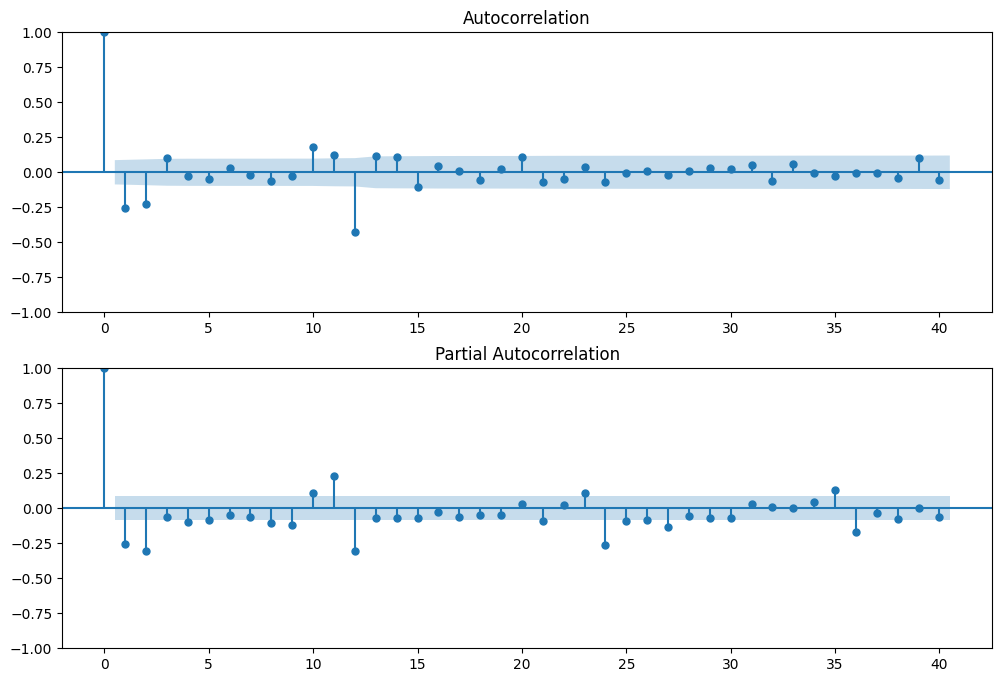

In [62]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. The lowest AIC  refore, we are interested in finding the model that yields the lowest AIC value.

The order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

### ARIMA

In [63]:
# Augmented Dickey-Fuller test
adf_result = adfuller(mte.dropna())
print(f"ADF p-value: {adf_result[1]}")

# If p-value > 0.05, difference the data
if adf_result[1] > 0.05:
    mte = mte.diff().dropna()

ADF p-value: 0.37569262885312726


In [64]:
train_size = int(0.7 * len(mte))
test_size = len(mte) - train_size

train = mte.iloc[:train_size]
test = mte.iloc[train_size:]

In [65]:
# Trouver la dernière date du dataset complet
last_date = pd.concat([train, test]).index[-1]

# Créer un index de dates pour l'année suivante (12 mois)
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                            periods=12, 
                            freq='M')

In [66]:
model = auto_arima(mte,           
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4384.430, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4366.292, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4357.589, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4382.490, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4296.883, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4145.583, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4325.197, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4124.806, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4196.905, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4111.765, Time=0.29 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4139.193, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4113.689, Time=0.38 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=4113.639, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : 

When fitting ARIMA models, it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

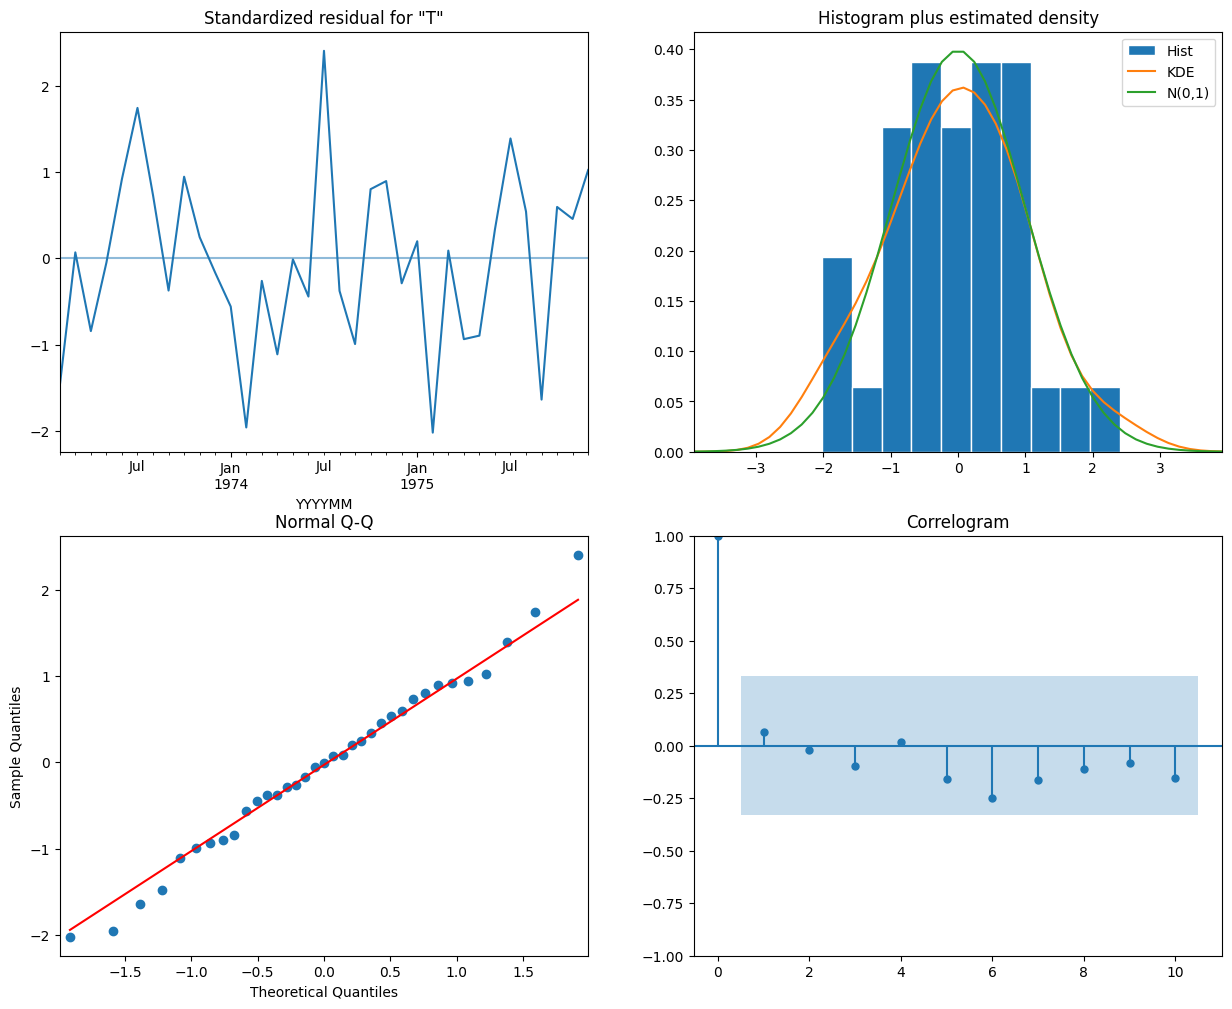

/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

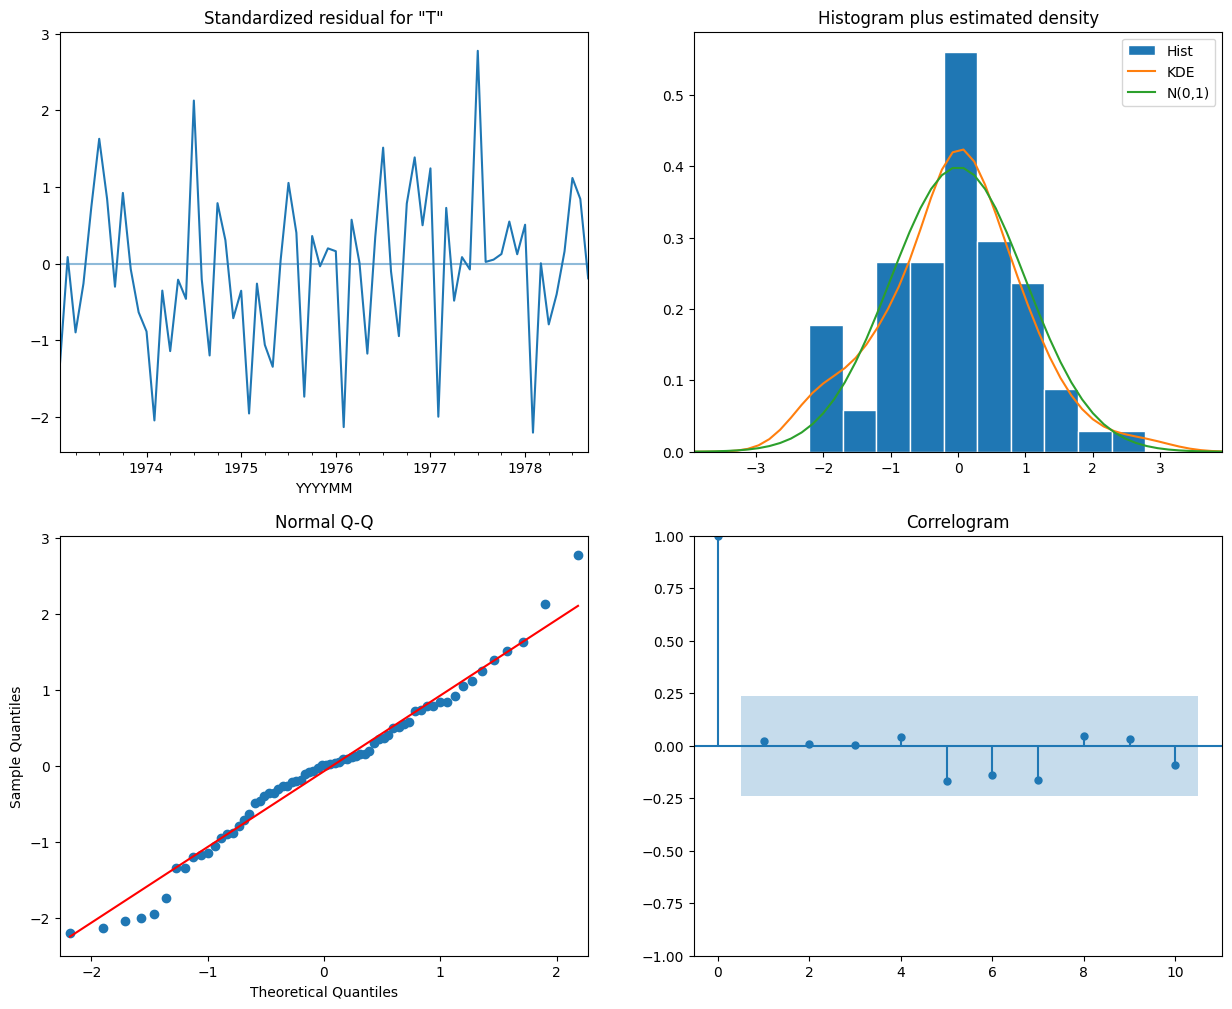

/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

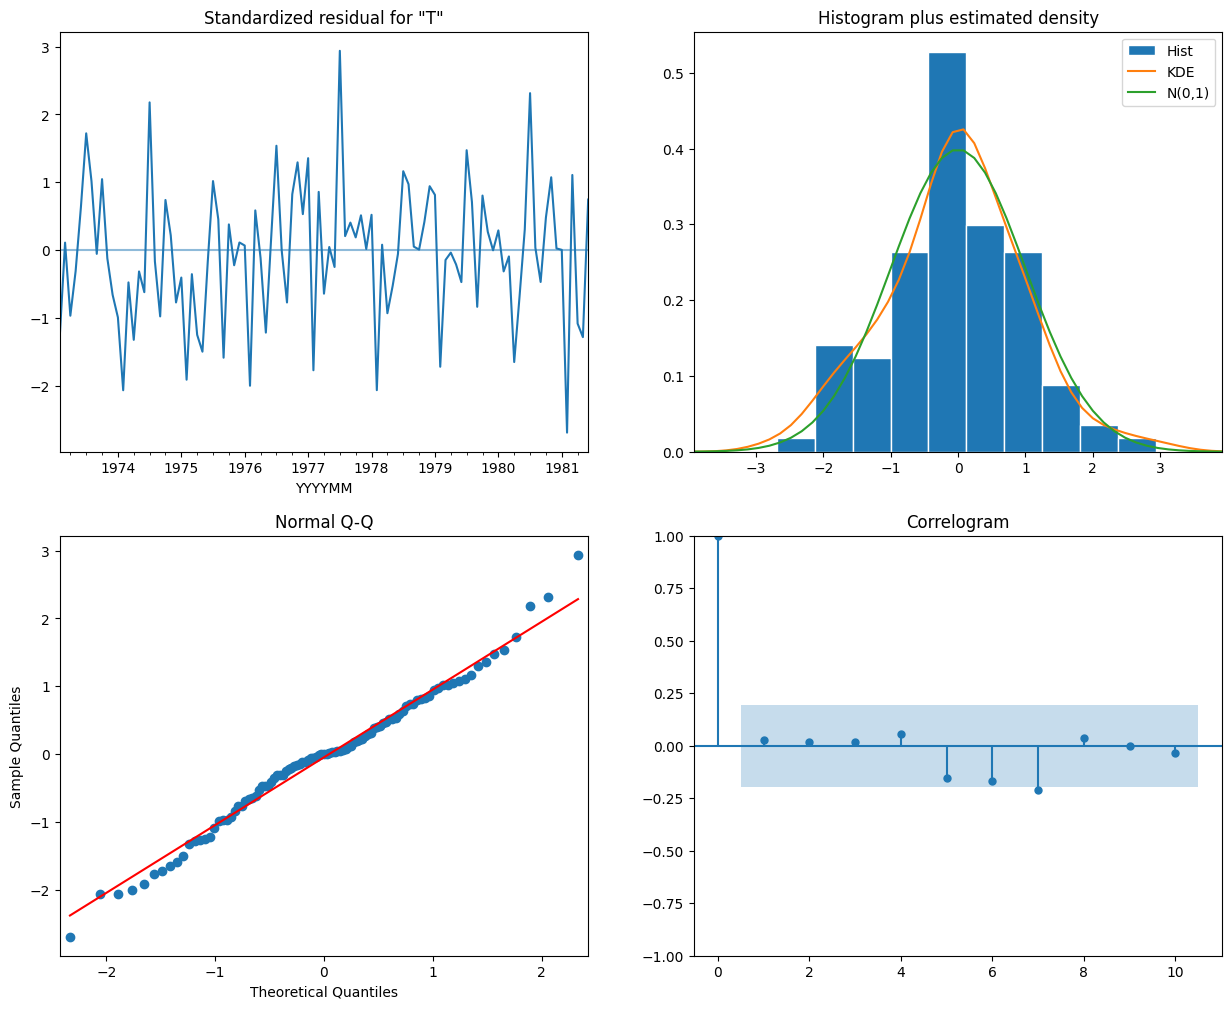

/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

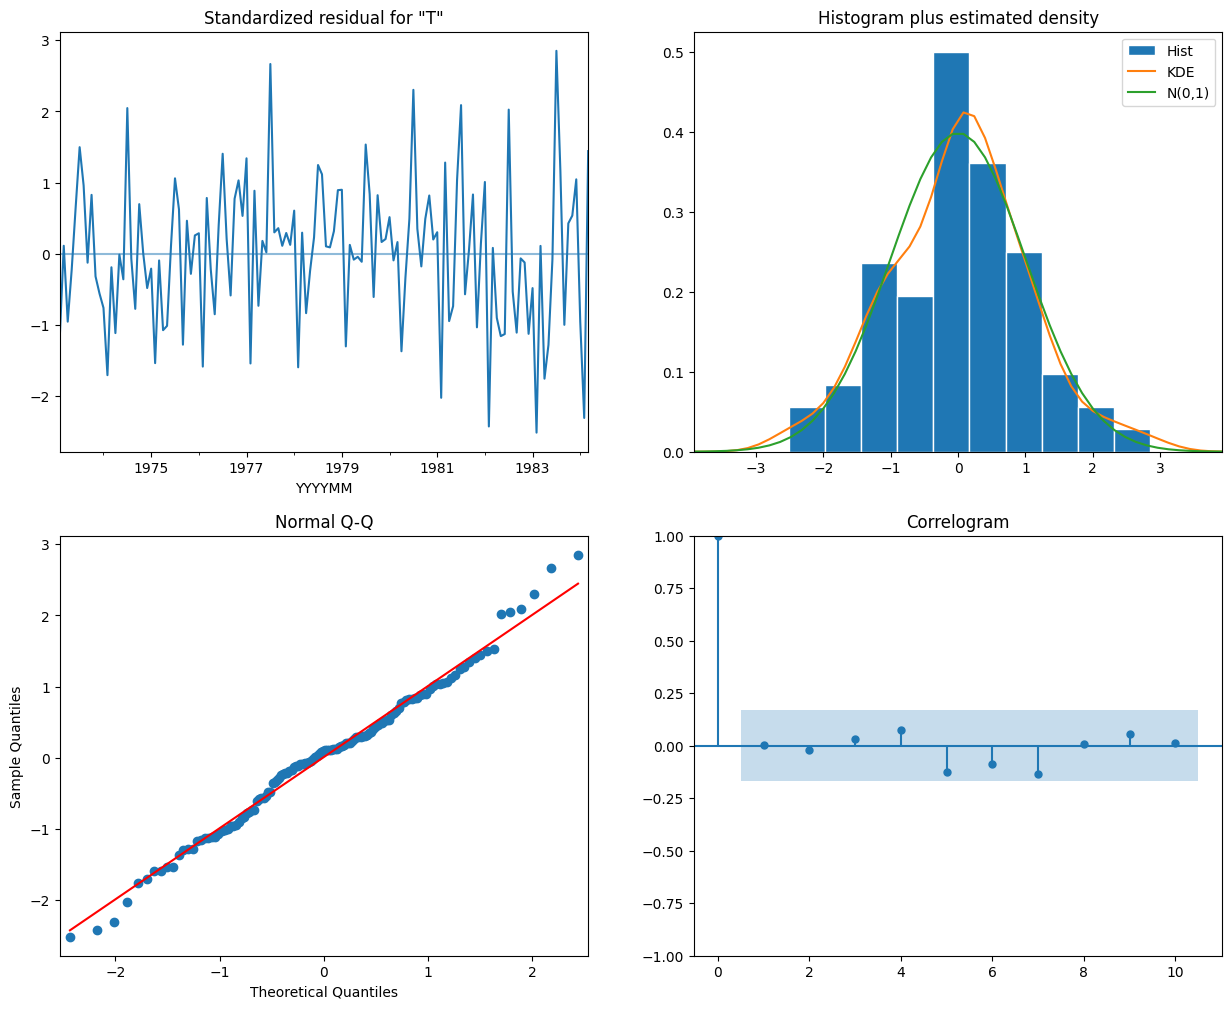

<Figure size 1200x800 with 0 Axes>

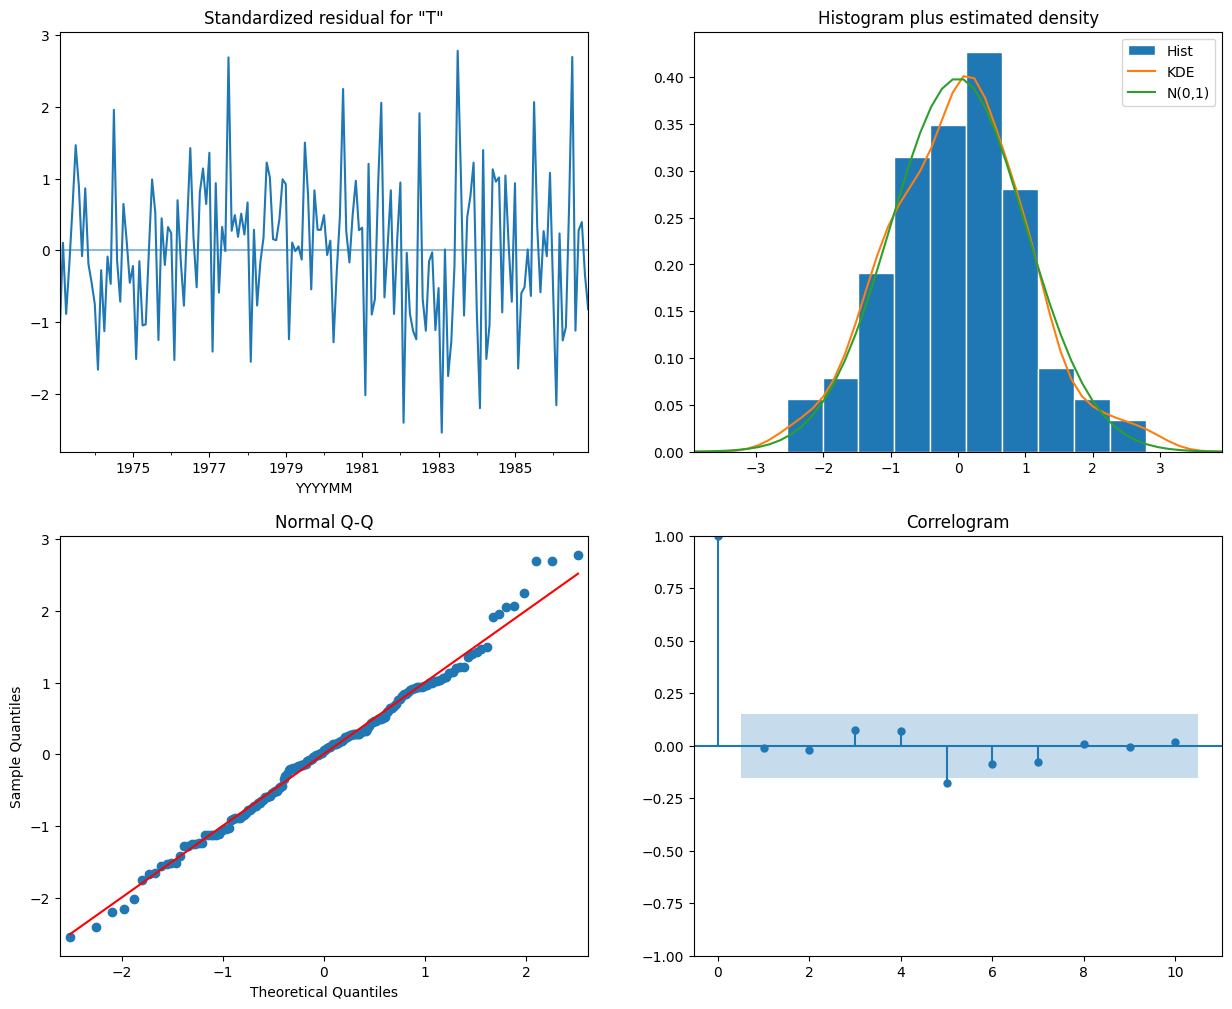

/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

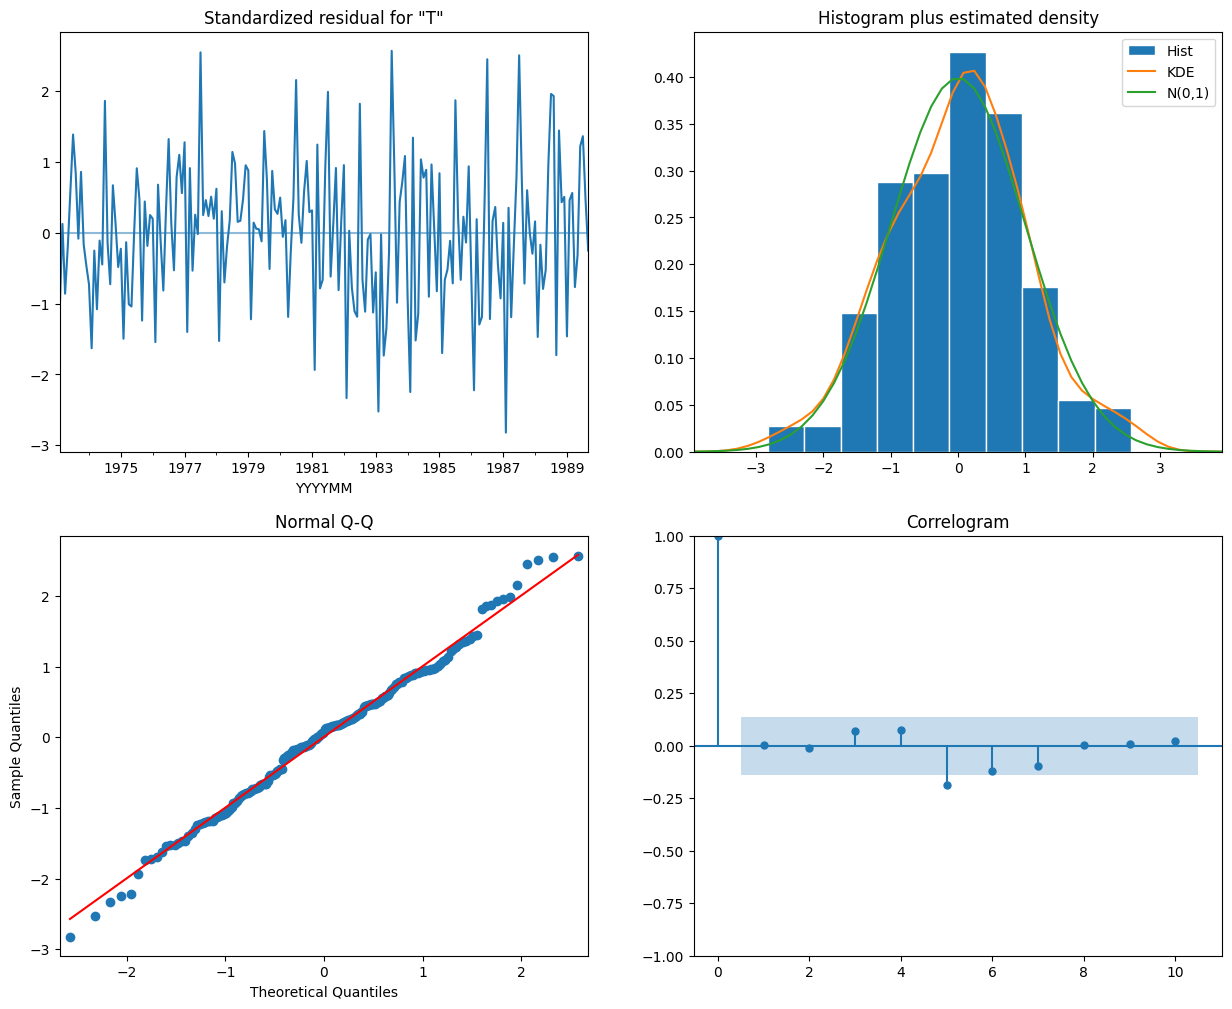

/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

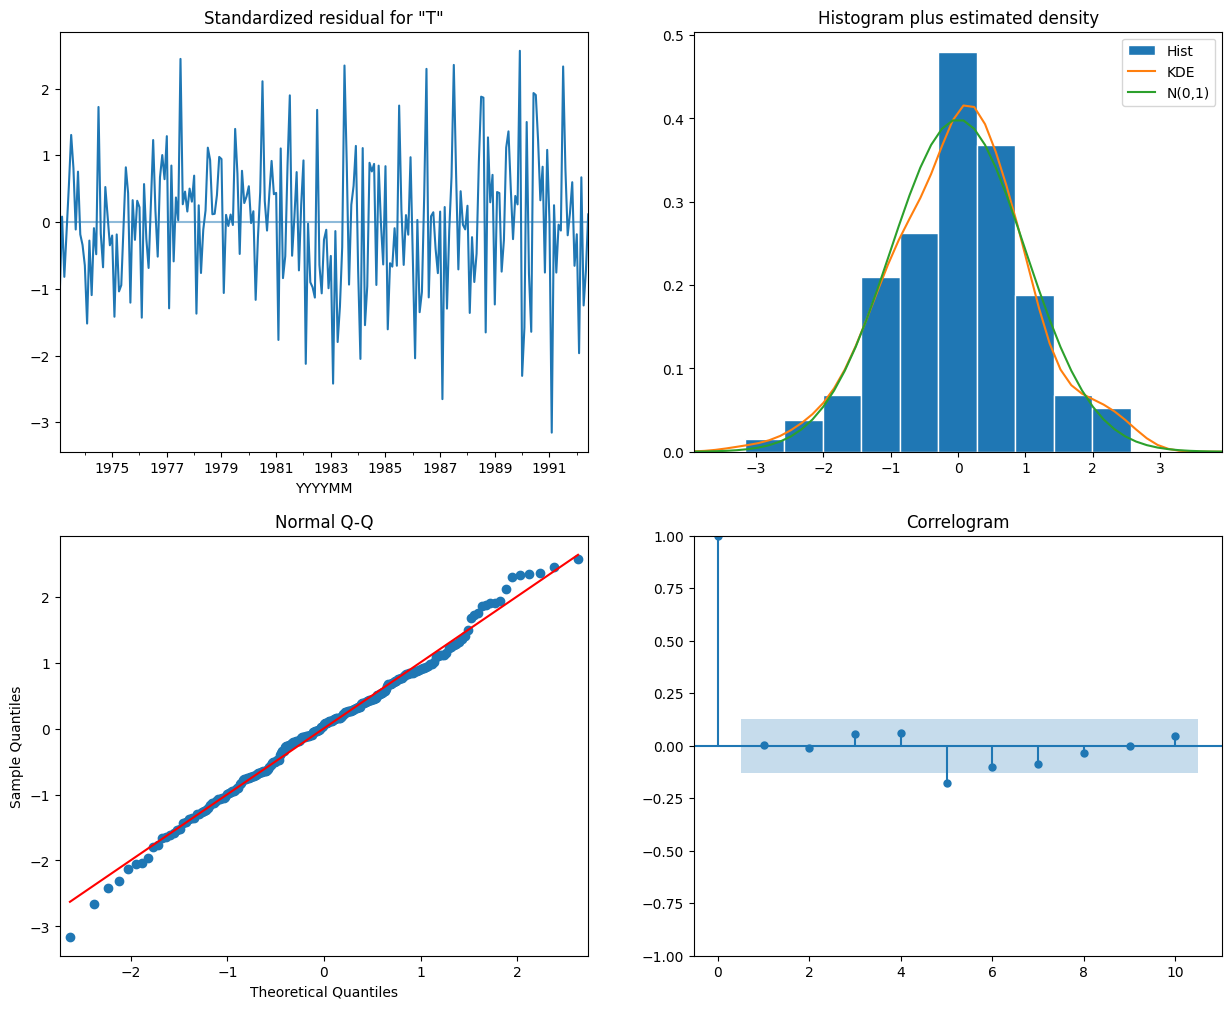

/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

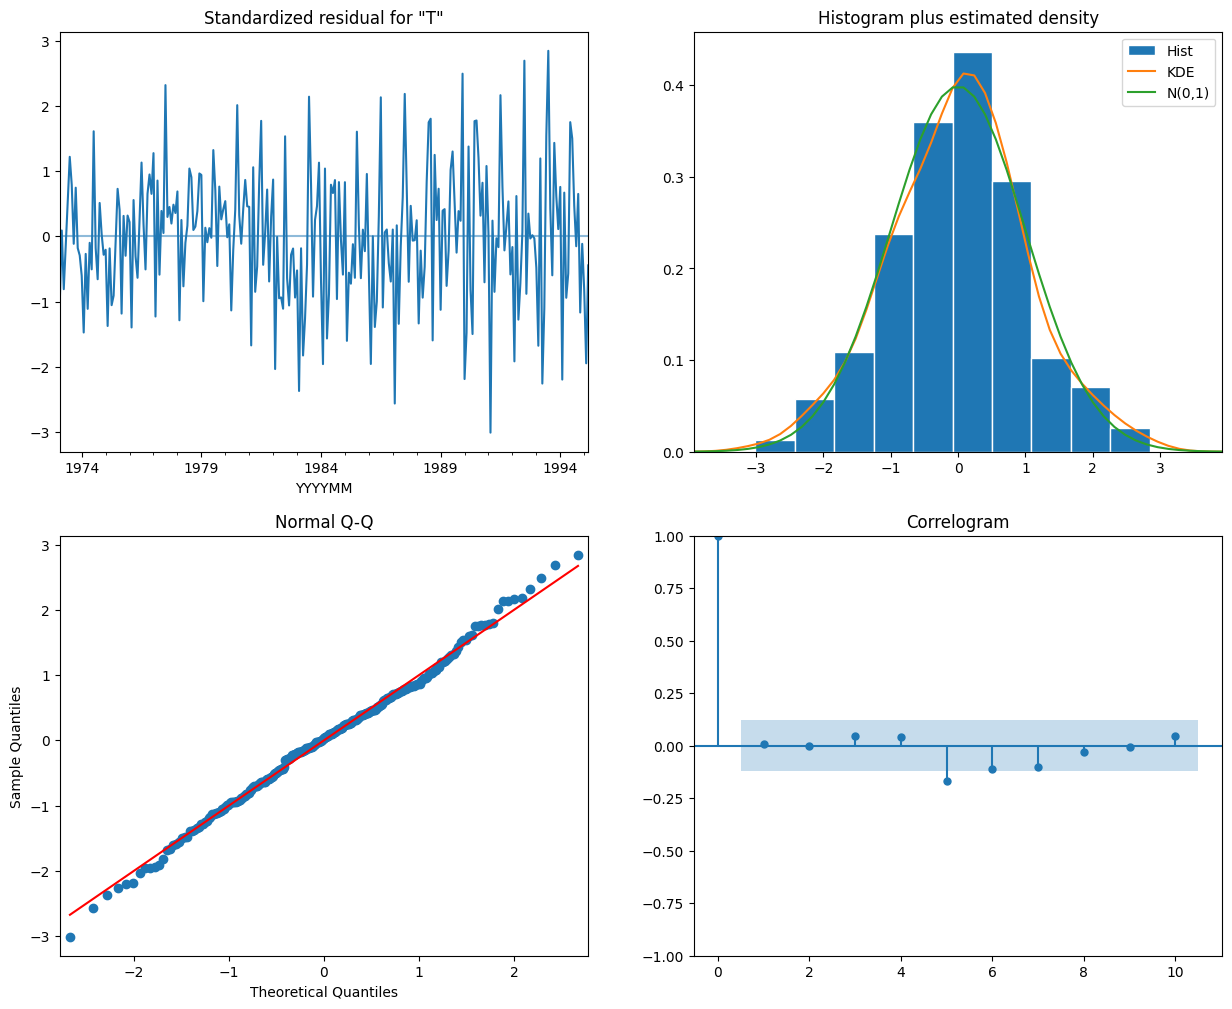

/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

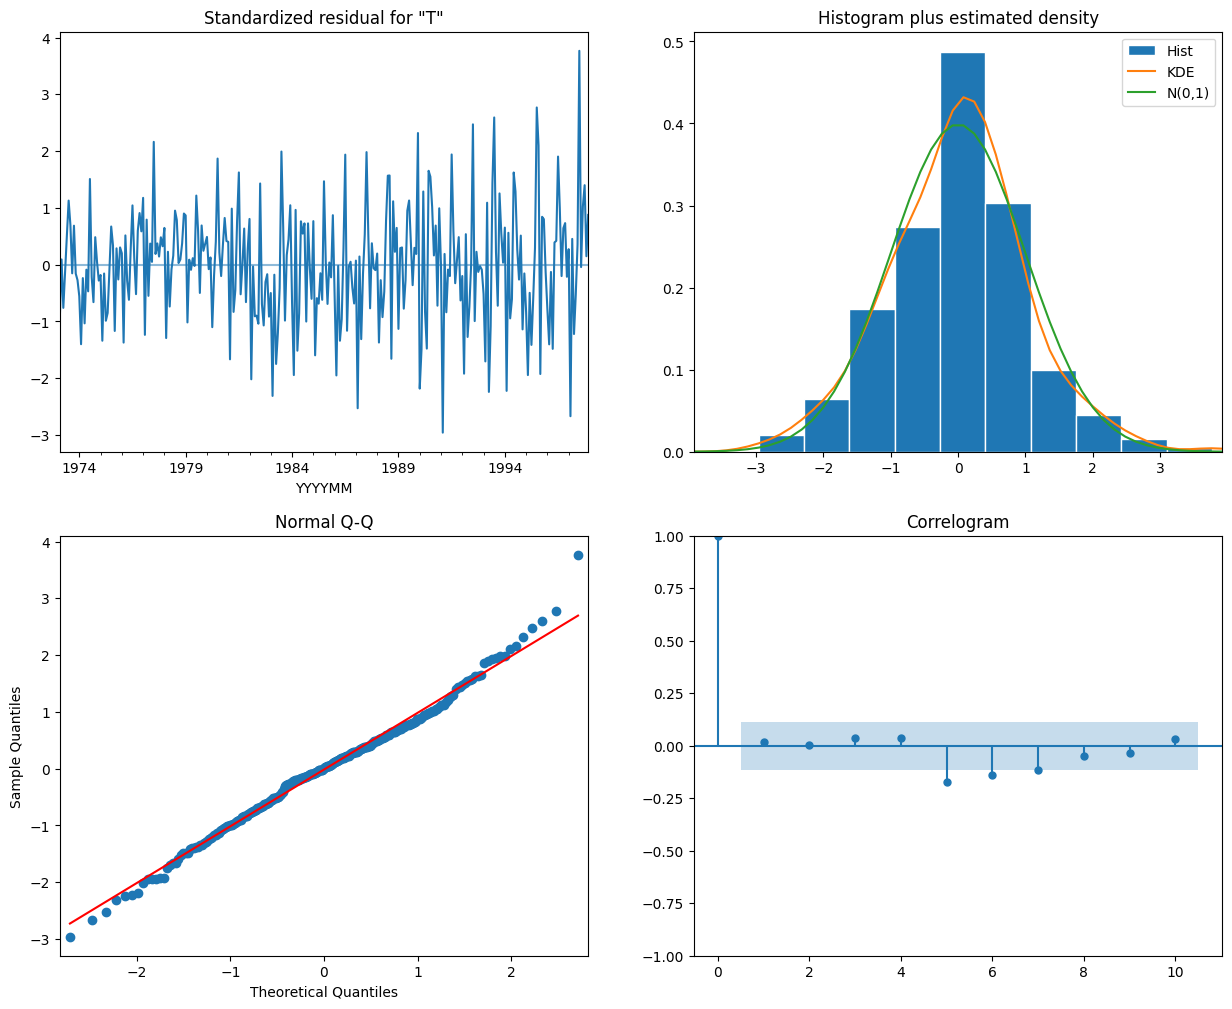

<Figure size 1200x800 with 0 Axes>

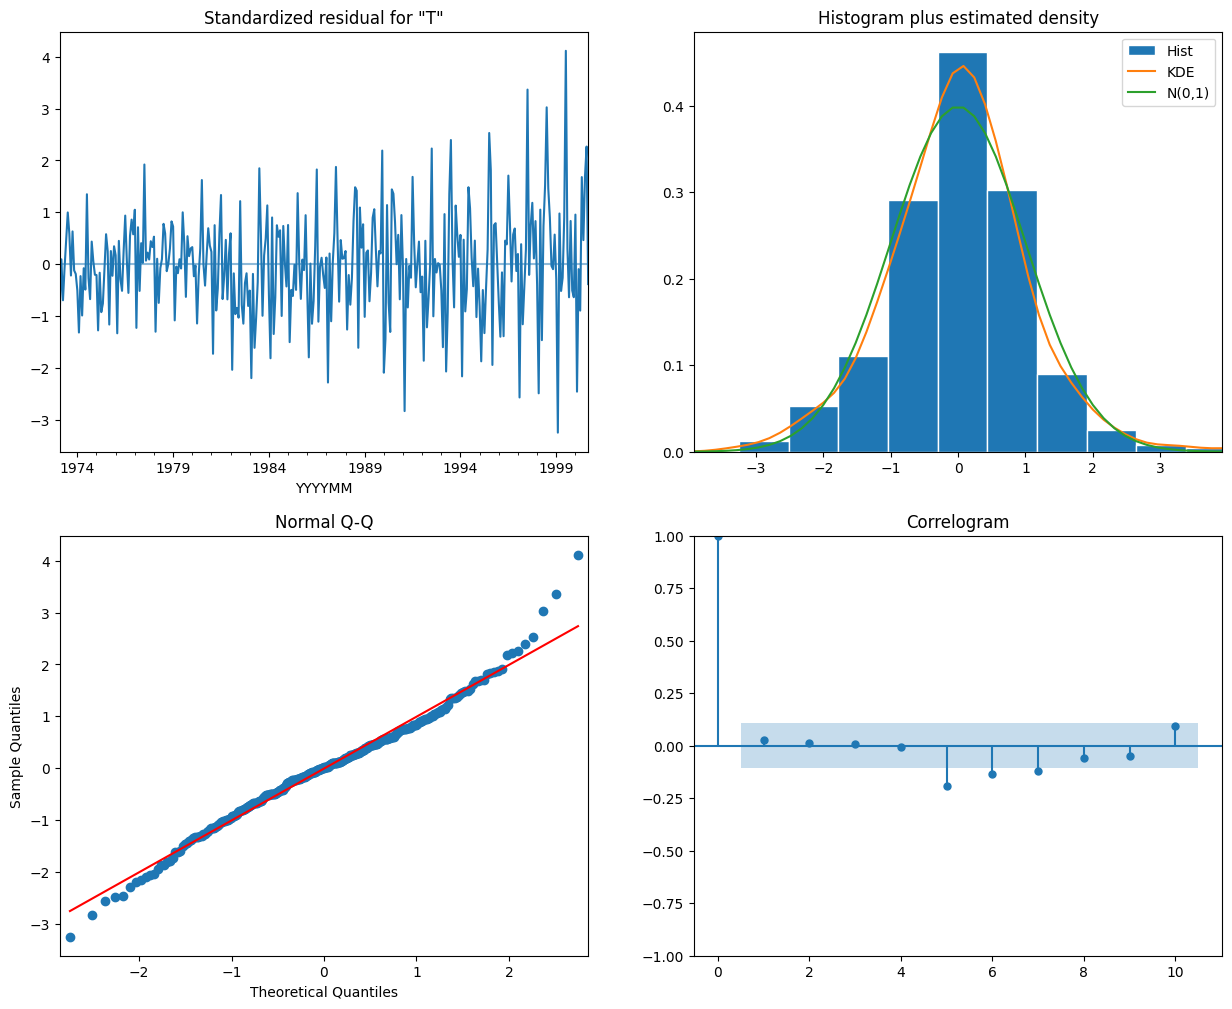

MSE moyen ARIMA: 197.05383760558686
RMSE moyen ARIMA: 13.765652051526667
MAE moyen ARIMA: 11.221386009111438
R² moyen ARIMA: 0.09560803187021051


In [67]:
# Stockage des résultats de validation croisée
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

# Validation croisée pour le modèle ARIMA
for train_index, val_index in tscv.split(train):
    train_cv, val_cv = train.iloc[train_index], train.iloc[val_index]
    model_arima = ARIMA(train_cv, order=(5, 0, 2))
    model_arima_fit = model_arima.fit()
    fig = plt.figure(figsize=(12,8))
    model_arima_fit.plot_diagnostics(figsize=(15, 12))
    plt.show()
    predictions_arima = model_arima_fit.forecast(steps=len(val_cv))
    
    mse = mean_squared_error(val_cv, predictions_arima)
    rmse = np.sqrt(mean_squared_error(val_cv, predictions_arima))
    mae = mean_absolute_error(val_cv, predictions_arima)
    r2 = r2_score(val_cv, predictions_arima)
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Affichage des résultats de validation croisée
print(f'MSE moyen ARIMA: {np.mean(mse_scores)}')
print(f'RMSE moyen ARIMA: {np.mean(rmse_scores)}')
print(f'MAE moyen ARIMA: {np.mean(mae_scores)}')
print(f'R² moyen ARIMA: {np.mean(r2_scores)}')
    

The model diagnostic suggests that the model residual is normally distributed based on the following:

- In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed. The forecast errors deviate somewhat from the straight line, indicating that the normal distribution is not a perfect model for the distribution of forecast errors, but it is not unreasonable.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

In [68]:
# Évaluation du modèle ARIMA sur l'ensemble de test
model_arima_final = ARIMA(train, order=(5, 0, 2))
start_train = time.time()
model_arima_final_fit = model_arima_final.fit()
end_train = time.time()
training_time_arima = end_train - start_train

start_inference = time.time()
predictions_arima_final = model_arima_final_fit.forecast(steps=len(test))
end_inference = time.time()
inference_time_arima = end_inference - start_inference

# Évaluation des performances
mse_test_arima = mean_squared_error(test, predictions_arima_final)
rmse_test_arima = np.sqrt(mean_squared_error(test, predictions_arima_final))
mae_test_arima = mean_absolute_error(test, predictions_arima_final)
r2_test_arima = r2_score(test, predictions_arima_final)
arima_par = 5 #(2+0+3)

# Prévision pour une année supplémentaire
year_forecast_arima = model_arima_final_fit.forecast(steps=12)

print(f'ARIMA - MSE Test: {mse_test_arima}, RMSE Test: {rmse_test_arima}, MAE Test: {mae_test_arima}, R² Test: {r2_test_arima}, Training Time: {training_time_arima}, Inference Time: {inference_time_arima}, Parameters: {arima_par}')

ARIMA - MSE Test: 378.12222794335094, RMSE Test: 19.445365204679263, MAE Test: 16.368448045223467, R² Test: 0.02499034738302286, Training Time: 0.2125682830810547, Inference Time: 0.008941650390625, Parameters: 5


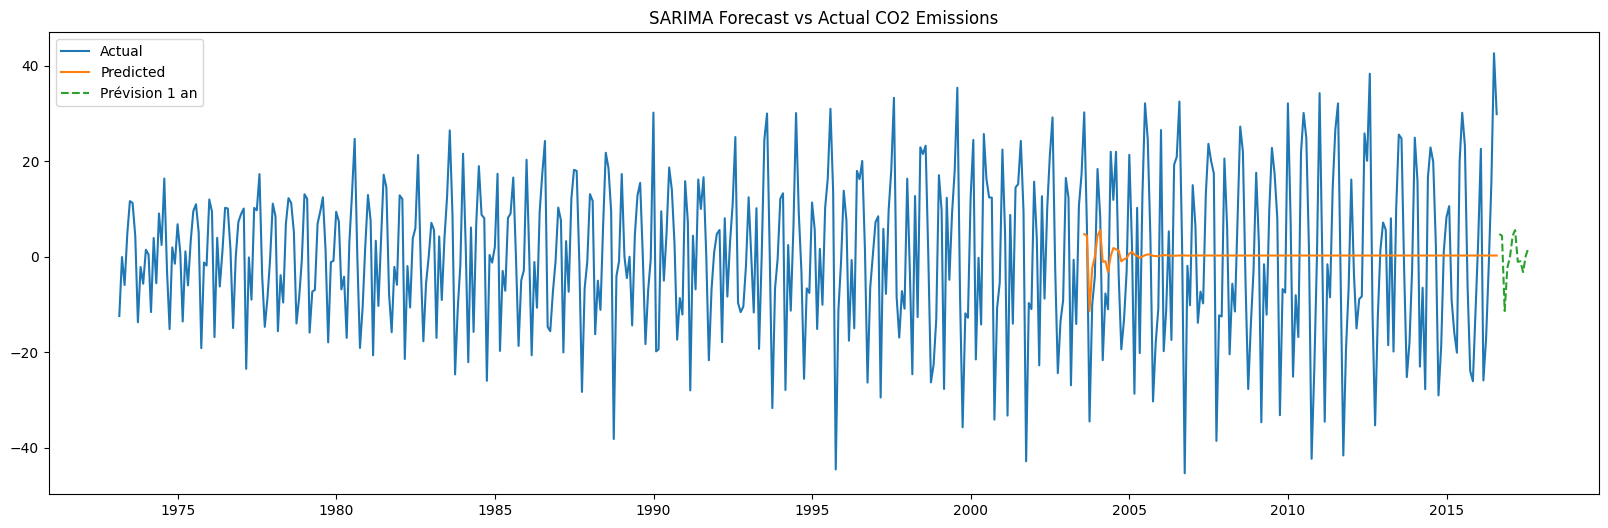

In [69]:
# Plot predictions vs actuals
plt.figure(figsize=(20, 6))
plt.plot(mte.index, mte, label="Actual")
plt.plot(test.index, predictions_arima_final, label="Predicted")
plt.plot(future_dates, year_forecast_arima, label='Prévision 1 an', linestyle='--')
plt.legend()
plt.title("SARIMA Forecast vs Actual CO2 Emissions")
plt.show()

### SARIMA

In [70]:
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets

In [71]:
best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                mte,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit(disp=False)
            aic = results.aic

            print(f"ARIMA{param}x{seasonal_param} - AIC:{aic:.2f}")

            if aic < best_aic:
                best_aic = aic
                best_order = param
                best_seasonal_order = seasonal_param
                best_model = results

        except Exception as e:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:4374.50
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:3981.17
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:3618.96
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:3317.93
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:3599.90
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:3385.32
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:3445.11
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:3319.93
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:4340.27
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:3971.57
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:3543.28
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:3266.42
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:3543.40
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:3323.54
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:3392.21
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:3267.69
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:4613.09
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:4280.35
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:4079.63
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:3753.91
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:4036.70
ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:3841.25
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:3891.79
ARIMA(0, 1,

When fitting seasonal ARIMA models, it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

<Axes: xlabel='YYYYMM'>

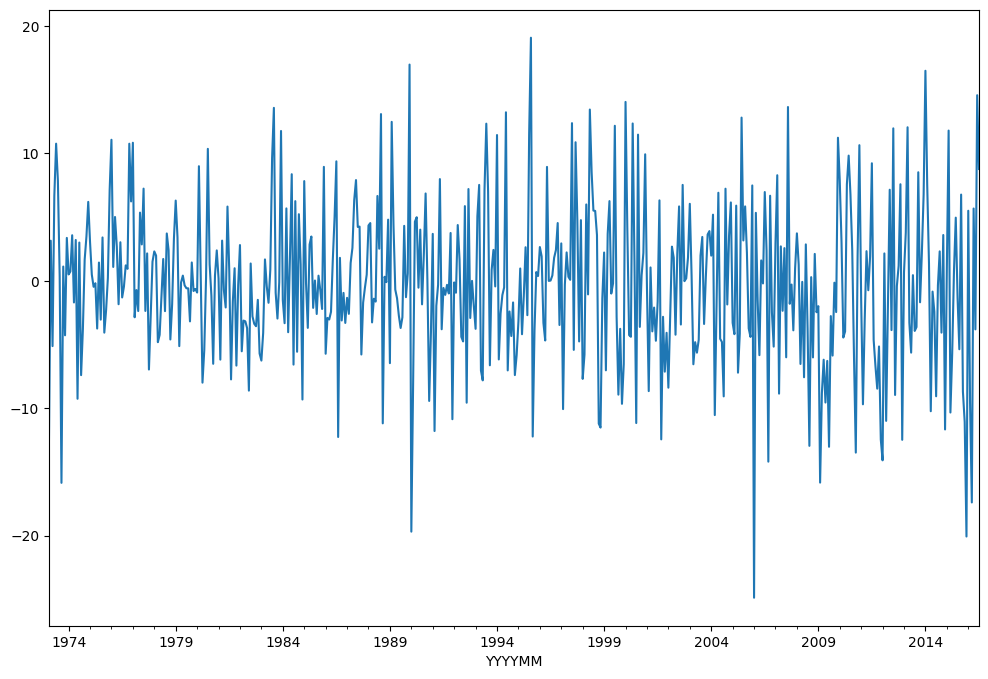

In [72]:
fig = plt.figure(figsize=(12,8))
best_model.resid.plot()

In [73]:
print(best_model.resid.describe())

count    522.000000
mean      -0.256793
std        6.186391
min      -24.875957
25%       -3.930900
50%       -0.333433
75%        3.388925
max       19.072182
dtype: float64


The figure displays the distribution of the residual errors. It shows a little bias in the prediction. Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

<Axes: ylabel='Density'>

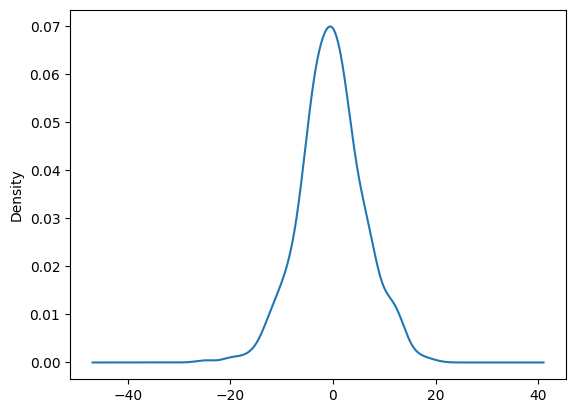

In [74]:
best_model.resid.plot(kind='kde')

The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

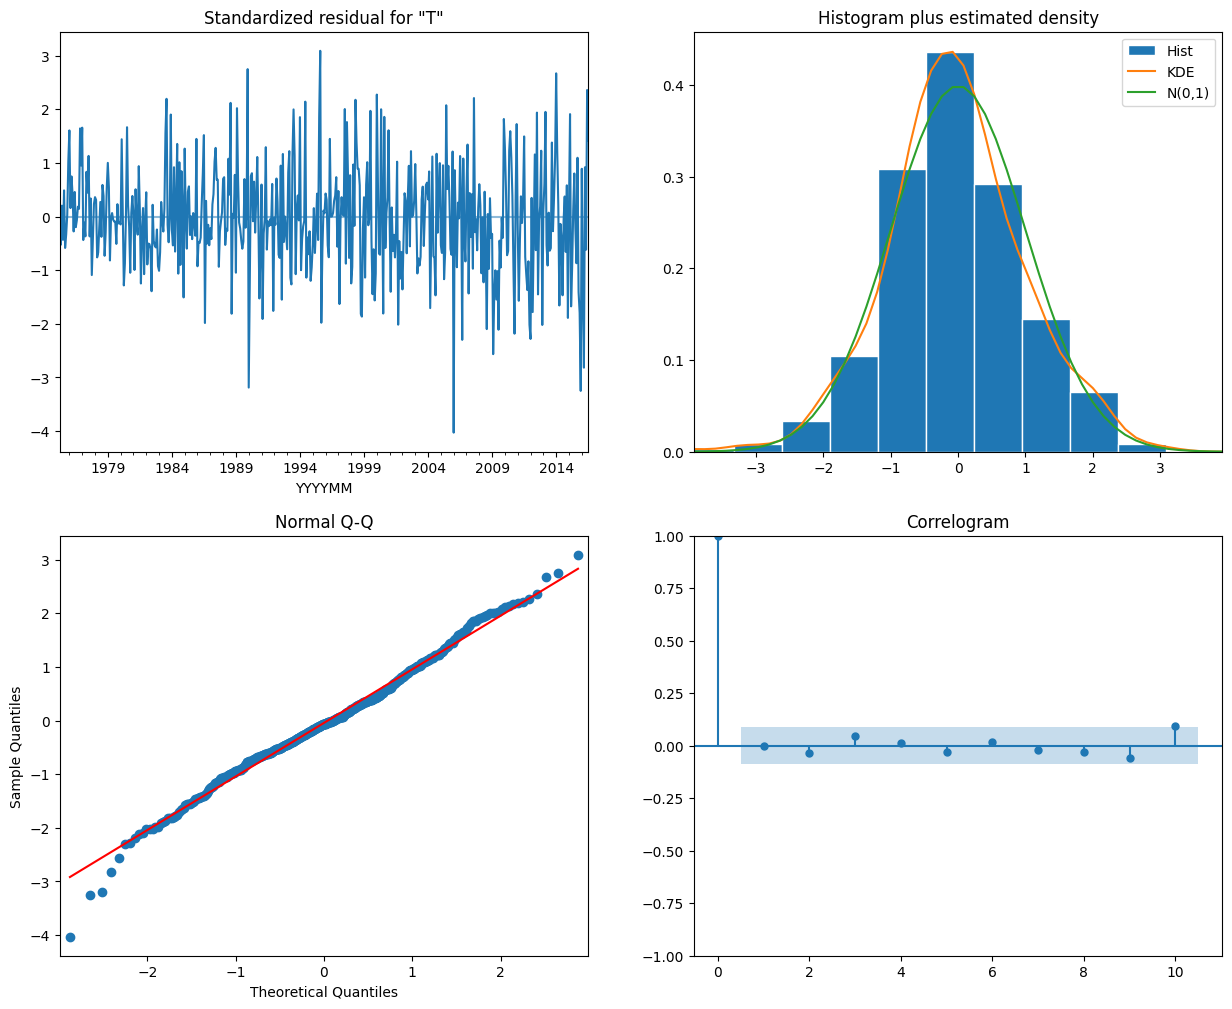

In [75]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The model diagnostic suggests that the model residual is normally distributed based on the following:

- In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed. The forecast errors deviate somewhat from the straight line, indicating that the normal distribution is not a perfect model for the distribution of forecast errors, but it is not unreasonable.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

In [76]:
best_order 

(1, 0, 1)

In [77]:
best_seasonal_order

(0, 1, 1, 12)

In [78]:
# Stockage des résultats de validation croisée
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

# Validation croisée pour le modèle ARIMA
for train_index, val_index in tscv.split(train):
    train_cv, val_cv = train.iloc[train_index], train.iloc[val_index]
    model_sarima = SARIMAX(train_cv, order=best_order, seasonal_order=best_seasonal_order)
    model_sarima_fit = model_sarima.fit(disp=False)
    predictions_sarima = model_sarima_fit.forecast(steps=len(val_cv))
    
    mse = mean_squared_error(val_cv, predictions_sarima)
    rmse = np.sqrt(mean_squared_error(val_cv, predictions_arima))
    mae = mean_absolute_error(val_cv, predictions_sarima)
    r2 = r2_score(val_cv, predictions_sarima)
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Affichage des résultats de validation croisée
print(f'MSE moyen SARIMA: {np.mean(mse_scores)}')
print(f'RMSE moyen ARIMA: {np.mean(rmse_scores)}')
print(f'MAE moyen SARIMA: {np.mean(mae_scores)}')
print(f'R² moyen SARIMA: {np.mean(r2_scores)}')

MSE moyen SARIMA: 39.02175604811858
RMSE moyen ARIMA: 15.10367786665979
MAE moyen SARIMA: 4.632899140973232
R² moyen SARIMA: 0.8110790085101816


In [79]:
# Évaluation du modèle ARIMA sur l'ensemble de test
model_sarima_final = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
start_train = time.time()
model_sarima_final_fit = model_sarima_final.fit(disp=False)
end_train = time.time()
training_time_sarima = end_train - start_train

start_inference = time.time()
predictions_sarima_final = model_sarima_final_fit.forecast(steps=len(test))
end_inference = time.time()
inference_time_sarima = end_inference - start_inference

# Évaluation des performances
mse_test_sarima = mean_squared_error(test, predictions_sarima_final)
rmse_test_sarima = np.sqrt(mean_squared_error(test, predictions_sarima_final))
mae_test_sarima = mean_absolute_error(test, predictions_sarima_final)
r2_test_sarima = r2_score(test, predictions_sarima_final)
sarima_par = 4 #(1+0+1+0+1+1)

n_forecast = 12  # or 365 if daily
sarima_forecast = best_model.forecast(steps=n_forecast)

print(f'SARIMA - MSE Test: {mse_test_sarima}, RMSE Test: {rmse_test_sarima}, MAE Test: {mae_test_sarima}, R² Test: {r2_test_sarima}, Training Time: {training_time_sarima}, Inference Time: {inference_time_sarima}, Parameters: {sarima_par}')

SARIMA - MSE Test: 71.83780001192443, RMSE Test: 8.47571825935268, MAE Test: 6.626452233376228, R² Test: 0.8147621502830882, Training Time: 0.820300817489624, Inference Time: 0.026726245880126953, Parameters: 4


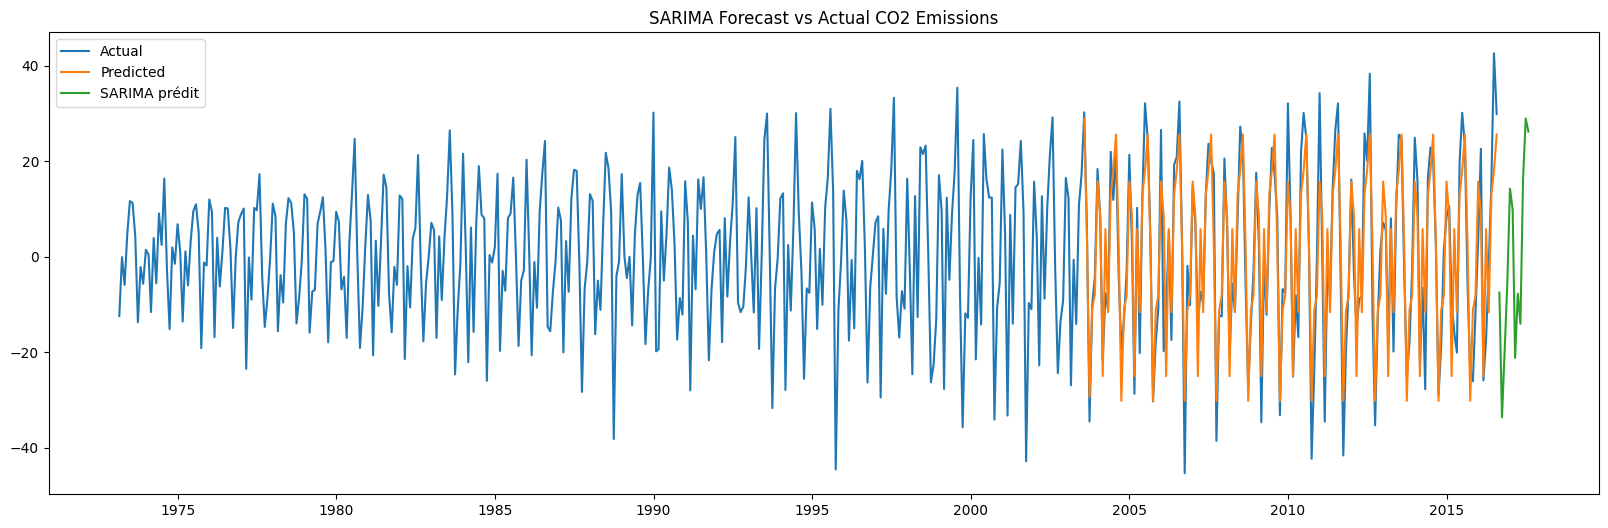

In [80]:
# Plot predictions vs actuals
plt.figure(figsize=(20, 6))
plt.plot(mte.index, mte, label="Actual")
plt.plot(test.index, predictions_sarima_final, label="Predicted")
plt.plot(future_dates, sarima_forecast, label='SARIMA prédit')
plt.legend()
plt.title("SARIMA Forecast vs Actual CO2 Emissions")
plt.show()

# Comparaison



=== Model Comparison ===
                    MSE       RMSE        MAE        R²  Training Time  \
ARIMA        378.122228  19.445365  16.368448  0.024990       0.212568   
SARIMA        71.837800   8.475718   6.626452  0.814762       0.820301   
LSTM         583.647840  24.158805  20.598163  0.127852       9.451508   
Transformer  268.339288  16.381065  13.765849  0.587658       0.000222   

             Inference Time  Parameters  
ARIMA              0.008942           5  
SARIMA             0.026726           4  
LSTM               0.280083       16961  
Transformer        0.016389      847809  


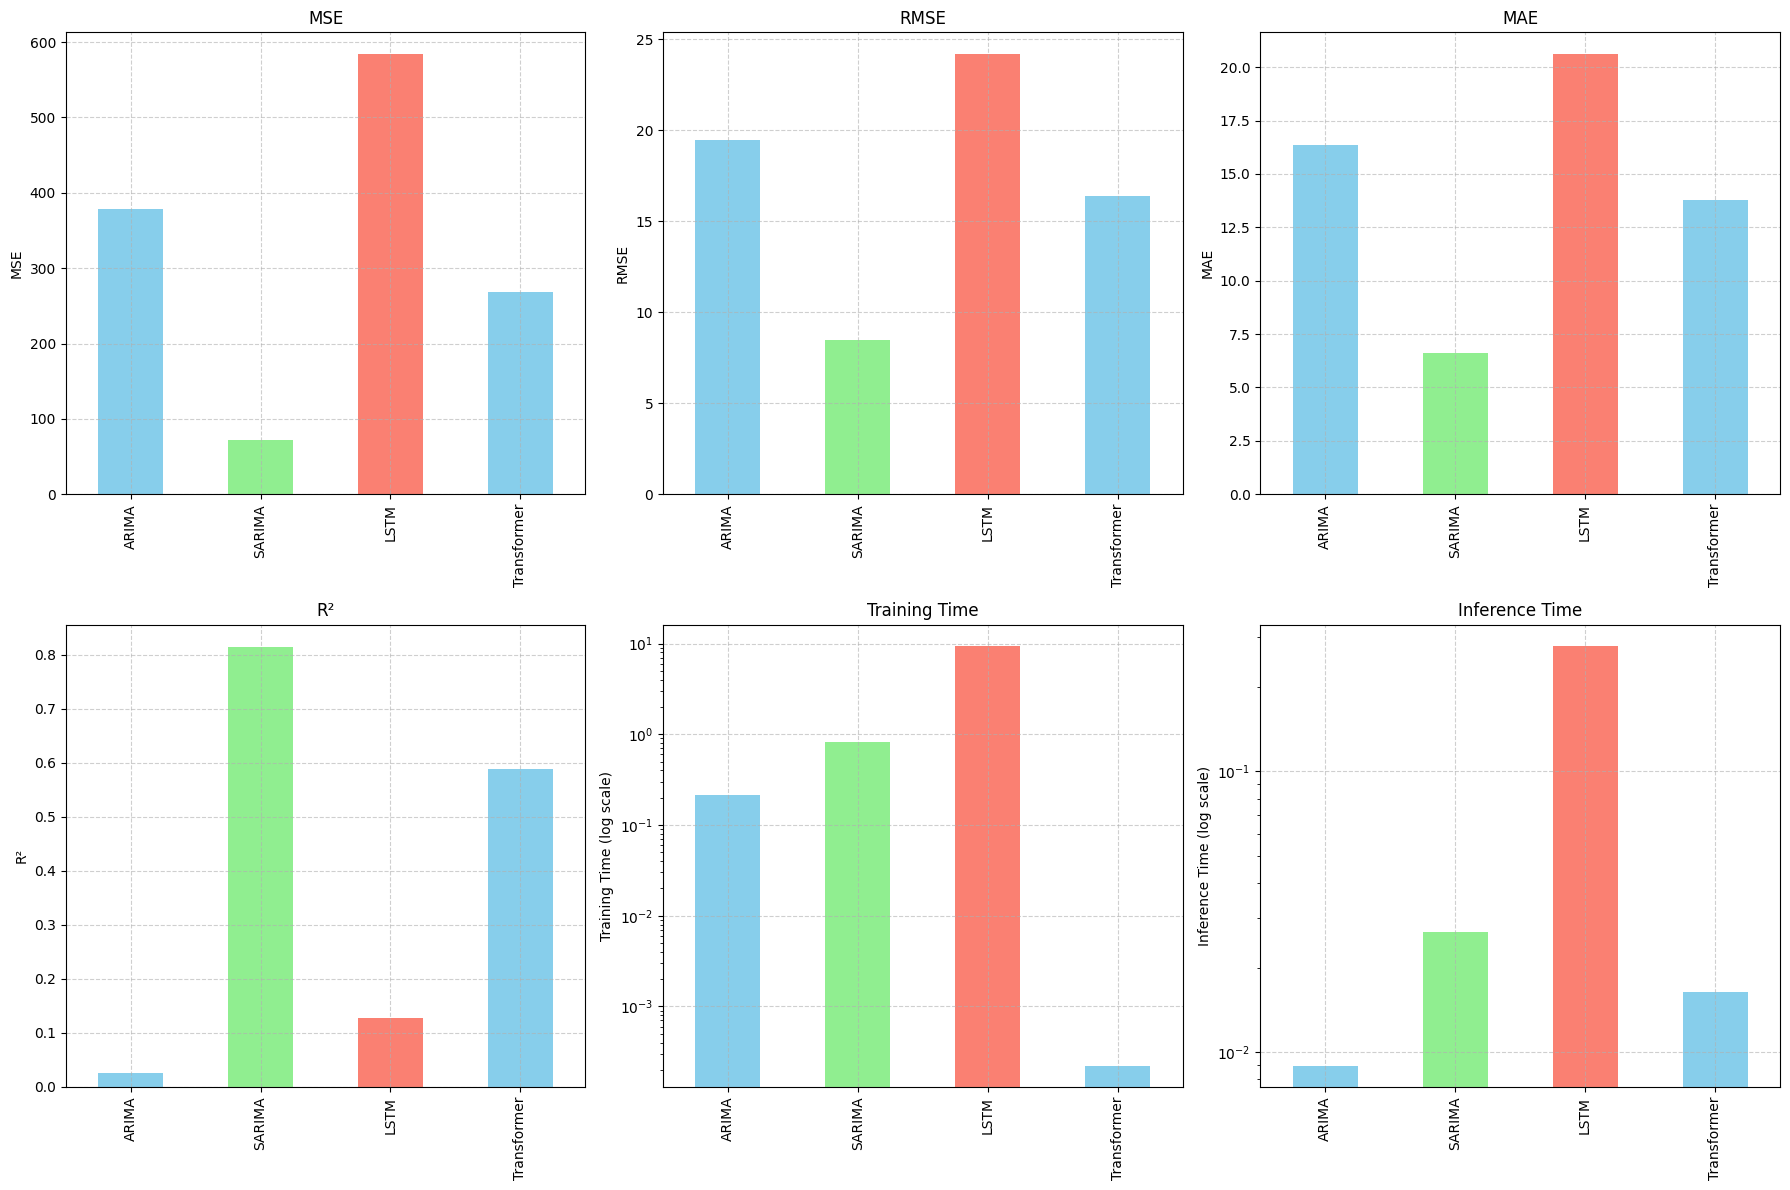

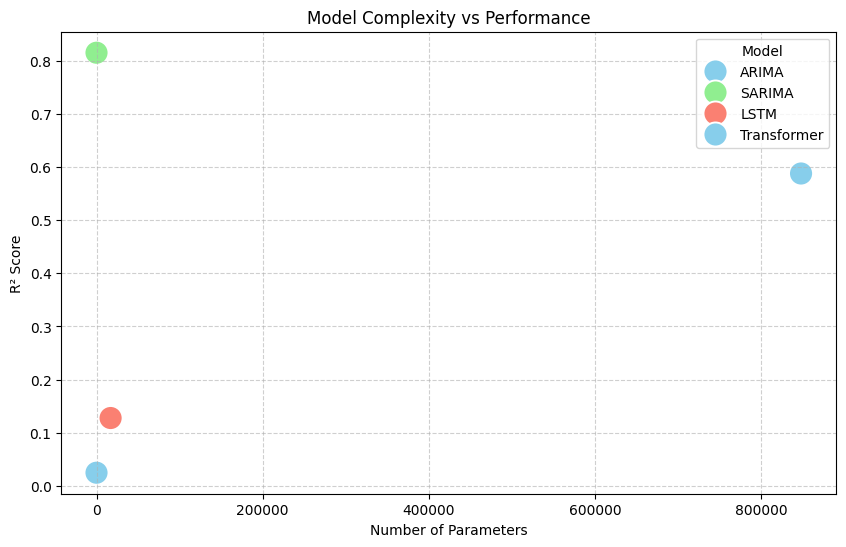

In [81]:
# Collect Metrics

metrics = {
    'ARIMA': {
        'MSE': mse_test_arima,
        'RMSE': rmse_test_arima,
        'MAE': mae_test_arima,
        'R²': r2_test_arima,
        'Training Time': training_time_arima,
        'Inference Time': inference_time_arima,
        'Parameters': arima_par
    },
    'SARIMA': {
        'MSE': mse_test_sarima,
        'RMSE': rmse_test_sarima,
        'MAE': mae_test_sarima,
        'R²': r2_test_sarima,
        'Training Time': training_time_sarima,
        'Inference Time': inference_time_sarima,
        'Parameters': sarima_par
    },
    'LSTM': {
        'MSE': mse_test_lstm,
        'RMSE': rmse_test_lstm,
        'MAE': mae_test_lstm,
        'R²': r2_test_lstm,
        'Training Time': training_time_lstm,
        'Inference Time': inference_time_lstm,
        'Parameters': lstm_par
    },
    'Transformer': {
    'MSE': mse_test_trans,
    'RMSE': rmse_test_trans,
    'MAE': mae_test_trans,
    'R²': r2_test_trans,
    'Training Time': training_time_trans,
    'Inference Time': inference_time_trans,
    'Parameters': trans_par
}
}

# Create Comparison DataFrame

df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
print("\n=== Model Comparison ===")
print(df_metrics)


# Advanced Visualizations

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['MSE', 'RMSE', 'MAE', 'R²', 'Training Time', 'Inference Time']

for i, metric in enumerate(metrics_to_plot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Bar plot for each metric
    df_metrics[metric].plot(kind='bar', ax=ax, color=['skyblue', 'lightgreen', 'salmon'])
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Special handling for time metrics
    if metric in ['Training Time', 'Inference Time']:
        ax.set_yscale('log')
        ax.set_ylabel(f'{metric} (log scale)')

plt.tight_layout()
plt.show()

# Additional visualization for parameters vs performance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_metrics, x='Parameters', y='R²', hue=df_metrics.index, 
                s=300, palette=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Complexity vs Performance')
plt.xlabel('Number of Parameters')
plt.ylabel('R² Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Model')
plt.show()